# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Наша работа будет разделена на следующие разделы:
1. Предобработка данных
    - общий отсмотр данных
    - удаление дубликатов (явных и неявных)
    - приведение типов данных к нужным для экономии памяти
    - заполнение (где возможно) пропущенных значений
    - удаление редких и уникальных значений столбцов
    - финальный вид, где будет дан итог предобработки - что получилось, а что нет.
2. Анализ данных
    - добавление новых (нужных нам) столбцов для анализа данных
    - конкретный обзор всех столбцов с пояснениями
    - изучение скорости продажи квартир с итоговым выводом
    - изучение факторов влияющих на полную стоимость квартиры
    - расчёт средней цены квадратного метра жилья в 10 населённых пунктах с наибольшим числом объявлений
    - расчёт зависимости цены от удалённости от центра города
3. Общий вывод, где будут собраны все основные промежуточные данные

## Откройте файл с данными и изучите общую информацию. 

In [1]:
#ячейка для импорта библиотек
import pandas as pd
import numpy as np

In [2]:
#сохраняем датафрейм в переменную и проверяем, что файл открывается нормально
try:
    estate_data = pd.read_csv(r'/datasets/real_estate_data.csv', sep='\t')
except:
    estate_data = pd.read_csv(r'https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


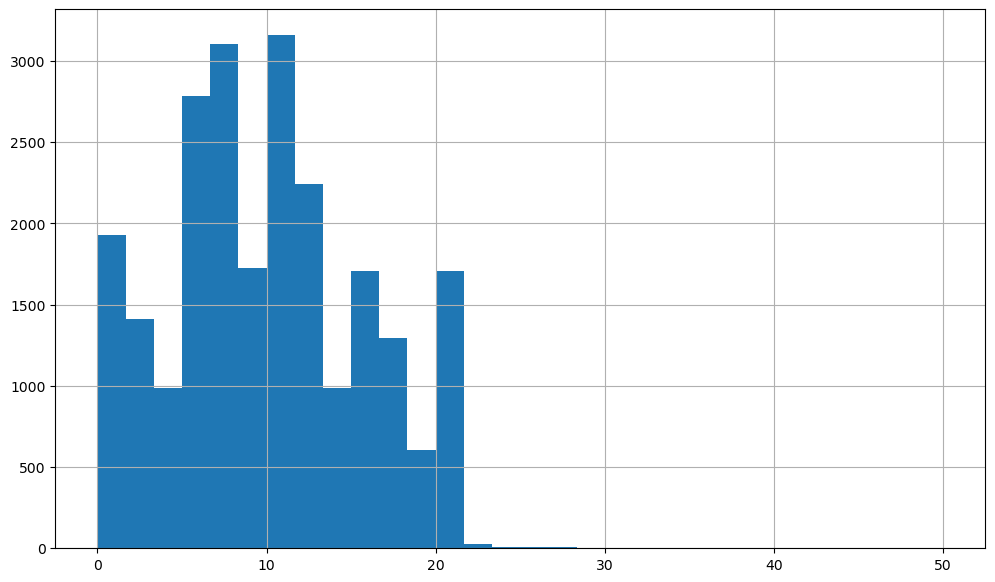

In [3]:
#строим гистограмму для столбца total_images
estate_data.total_images.hist(bins=30, figsize=(12, 7));

По поводу фотографий квартиры для продажи: примерно половина пользователей делает до 10 фотографий квартиры, ещё процентов 35-40% делают от 10 до 20 фотографий, большее количество фотографий квартиры для продажи делает уже не так много продавцов. в основном до 24. Более совсем уж редко. Есть продавец, который сделал около 50 фотографий квартиры. Выглядит как аномалия (для данного столбца).

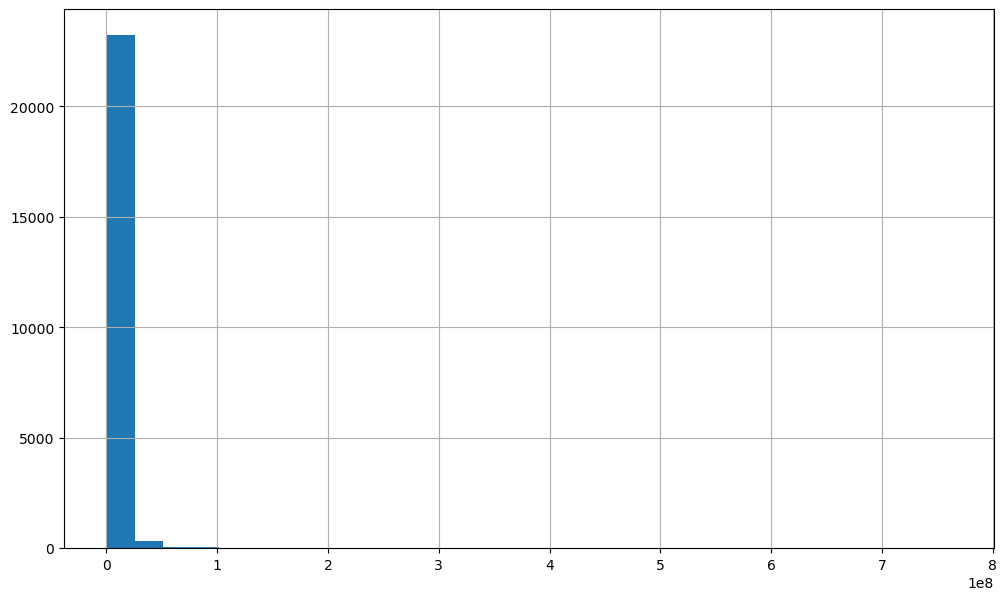

In [4]:
#строим гистограмму для столбца last_price
estate_data.last_price.hist(bins=30, figsize=(12, 7));

Предварительно: виден огромный разброс цен (минимум на порядок, а то и не на один) - но пока не ясно с чем он связан.

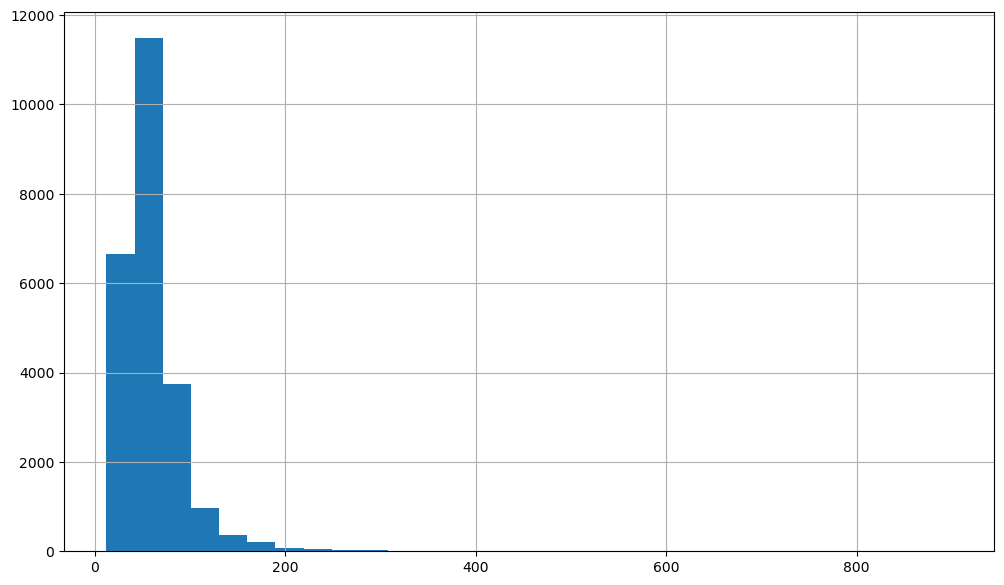

In [5]:
#строим гистограмму для столбца total_area
estate_data.total_area.hist(bins=30, figsize=(12, 7));

Предварительный вывод: видно, что почти все значения площади квартир лежат до приблизительно 400 метров - далее только выбросы - сверхредкие аномально большие квартиры до 800+ метров  

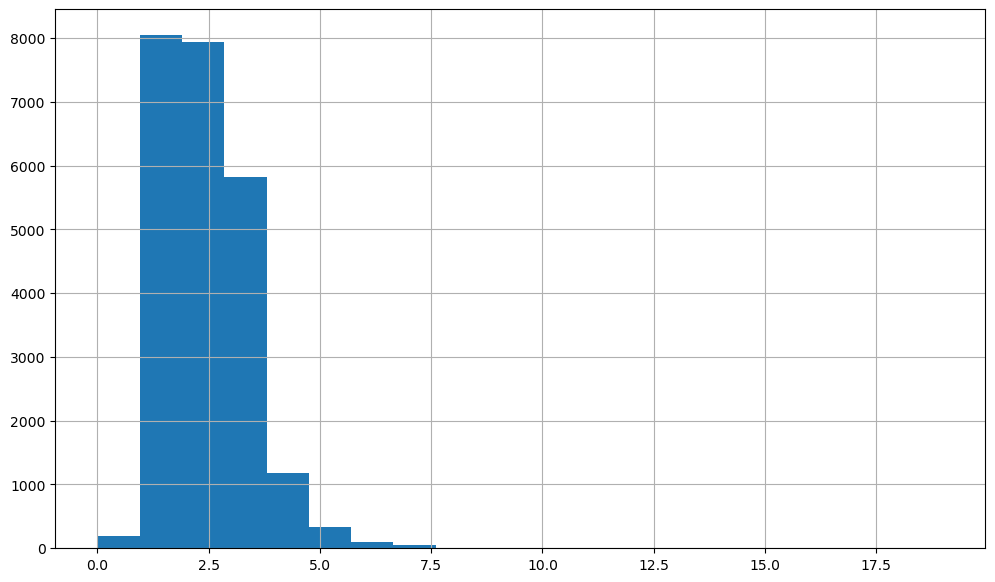

In [6]:
#строим гистограмму для столбца rooms
estate_data.rooms.hist(bins=20, figsize=(12, 7));

Основная масса квартир имеет не более 9 комнат - далее идут очень редкие значения для этого столбца. Из-за них могут исказиться данные.

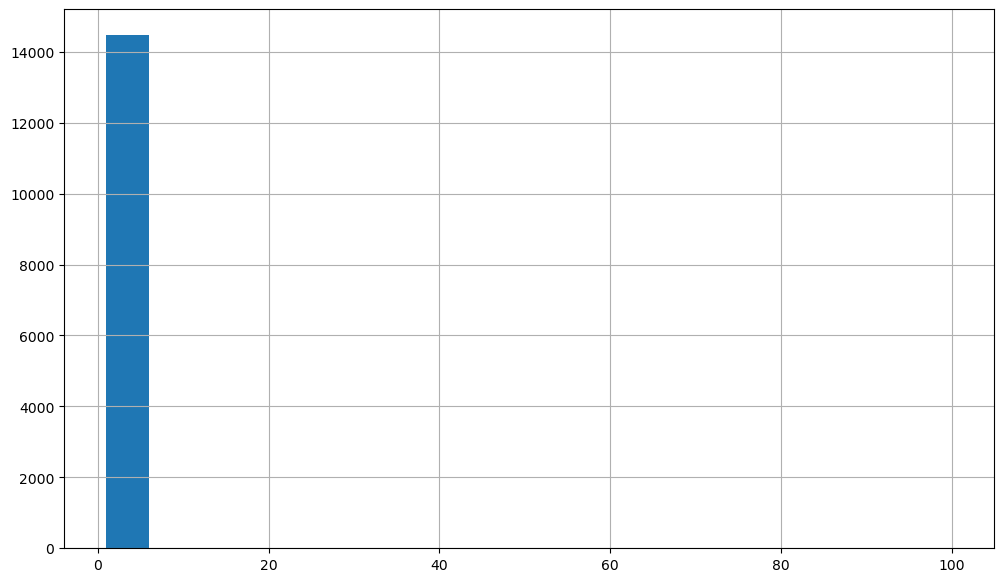

In [7]:
#строим гистограмму для столбца ceiling_height
estate_data.ceiling_height.hist(bins=20, figsize=(12, 7));

Даже не увидеть нормального распредения данных из-за очень больших выбросов по высоте потолка - аж до 100 метров! Где ж это видано, где ж это слыхано...

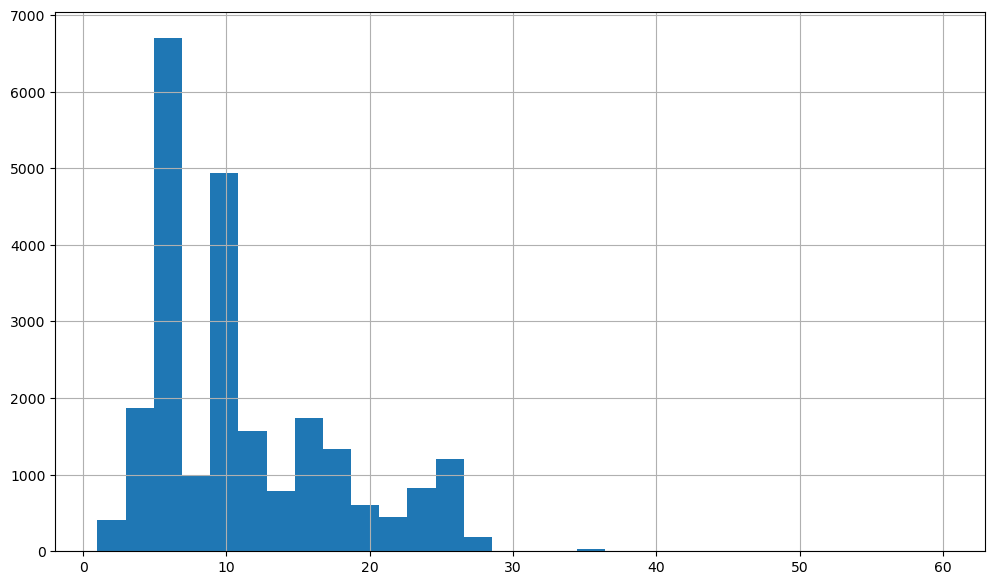

In [8]:
#строим гистограмму для столбца floors_total
estate_data.floors_total.hist(bins=30, figsize=(12, 7));

И вновь выбросы: по гистограмме можно явно понять, что дома свыше 30 этажей огромная редкость, а под 60 - это уже недостроенный небоскрёб. Будем удалять лишнее, чтоб не мешало анализировать данные...

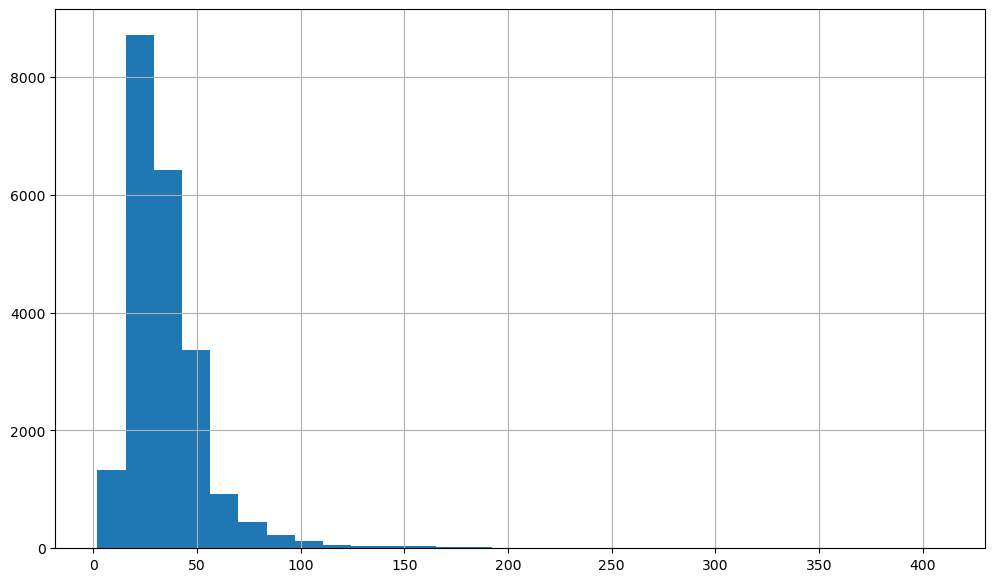

In [9]:
#строим гистограмму для столбца living_area
estate_data.living_area.hist(bins=30, figsize=(12, 7));

Жилая площадь свыше 200 метров - огромная редкость, для жизни - хорошо, а вот анализ с этого и пострадать может...

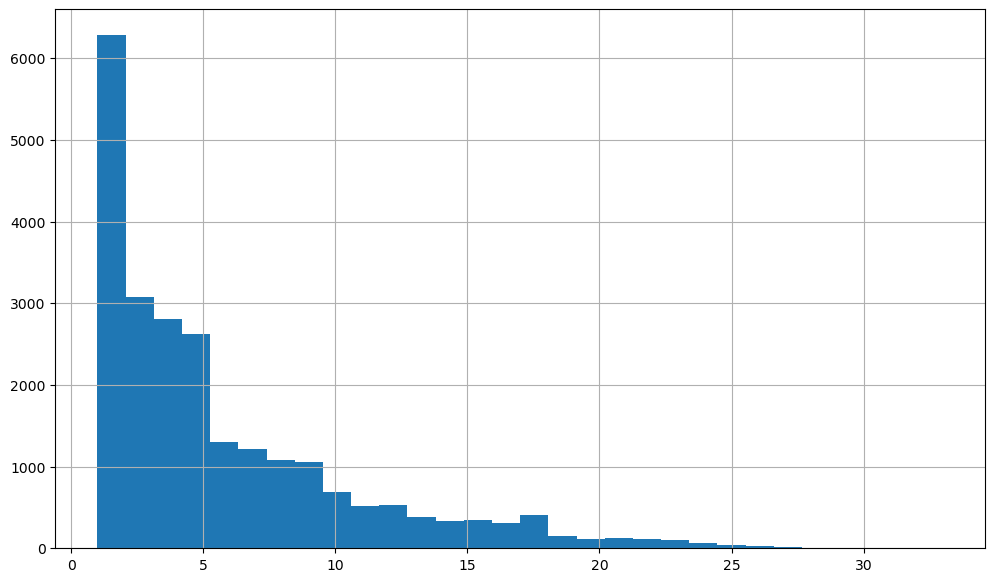

In [10]:
#строим гистограмму для столбца floor
estate_data.floor.hist(bins=30, figsize=(12, 7));

Уже устали от сильных искажений - И вот: график почти нормальный, надо только подчистить этажи выше 27го уж слишком редко встречаются.

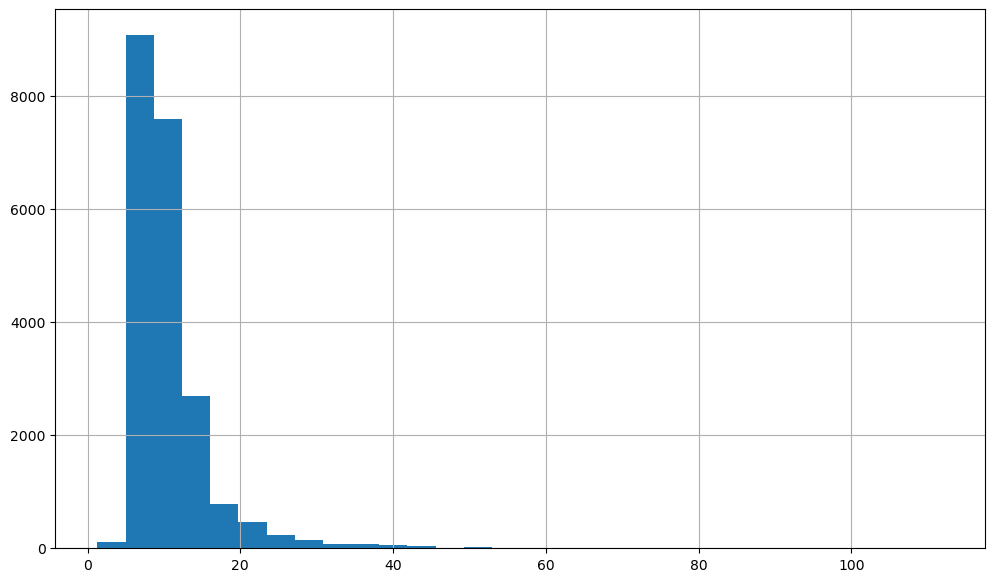

In [11]:
#строим гистограмму для столбца kitchen_area
estate_data.kitchen_area.hist(bins=30, figsize=(12, 7));

Площадь кухни распределена нормально до 62-63 метров - далее уже редкие кухни - столовые, их мало и надо удалять.

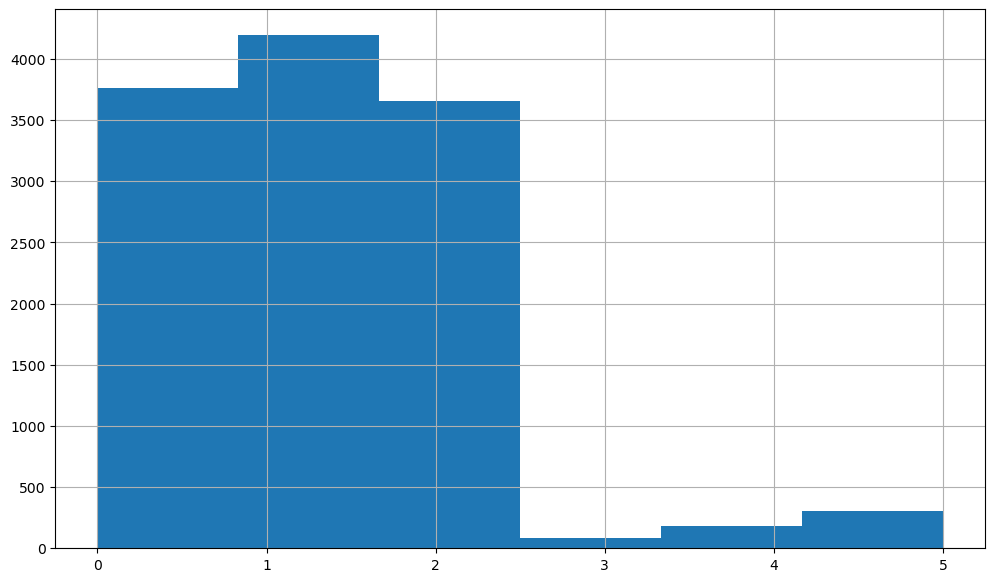

In [12]:
#строим гистограмму для столбца balcony
estate_data.balcony.hist(bins=6, figsize=(12, 7));

Количество балконов не более 5. По большей части их или нет или 1 или 2. Остальное редкость. Удалять тут нечего.

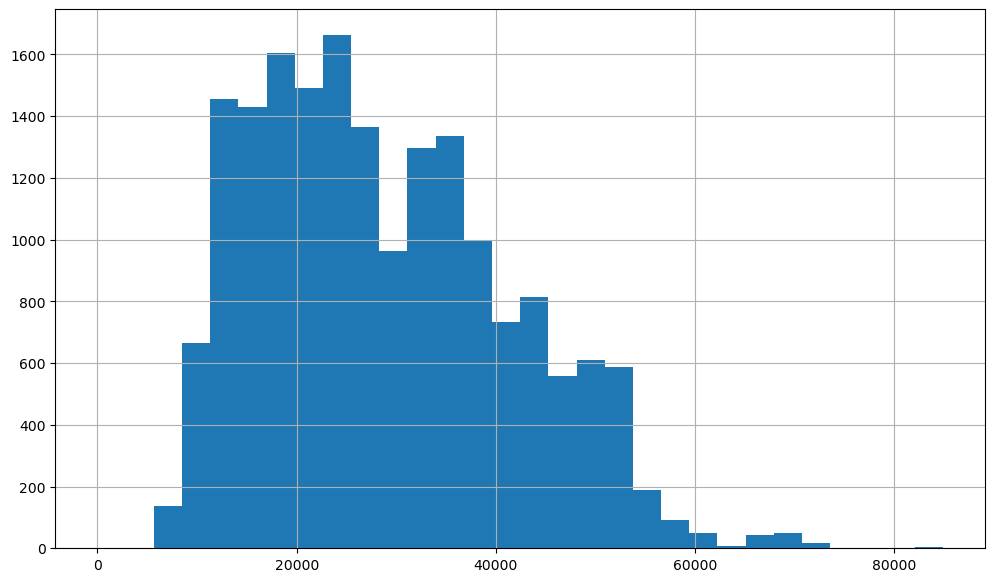

In [13]:
#строим гистограмму для столбца airports_nearest
estate_data.airports_nearest.hist(bins=30, figsize=(12, 7));

В основном аэропорт находяться в пределах 60 километрах от квартиры, дальше - реже. 

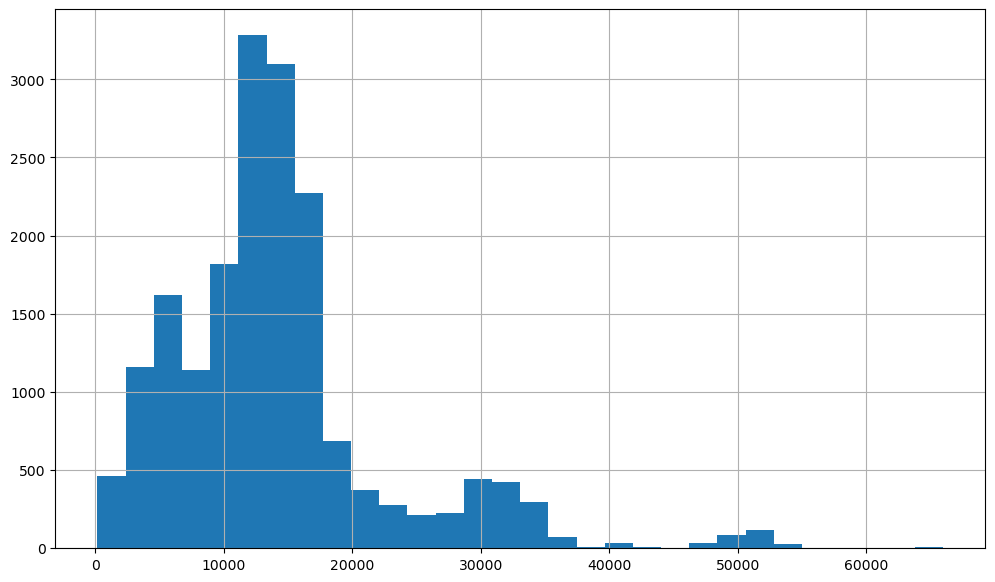

In [14]:
#строим гистограмму для столбца cityCenters_nearest
estate_data.cityCenters_nearest.hist(bins=30, figsize=(12, 7));

Расстояние до центра города по моде - примерно 12-13 километров. в пределах 20 километров - основная часть всех значений. в районе 50 километров - последний крупный населённый пункт. После 55 километров - отдельные квартиры, но это уже аномалии - они слишком редки. Их надо удалять.

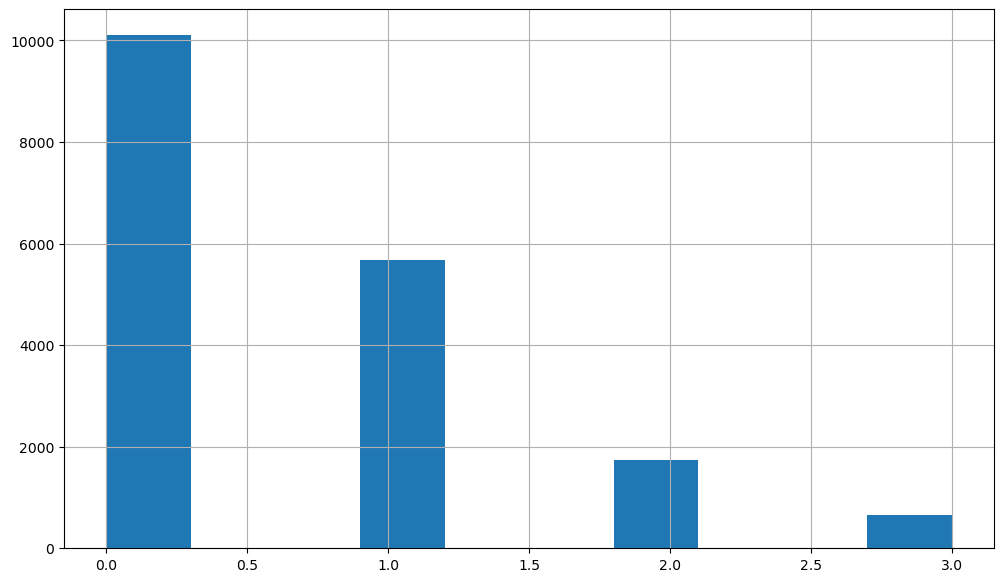

In [15]:
#строим гистограмму для столбца parks_around3000
estate_data.parks_around3000.hist(figsize=(12, 7));

Парков не более трёх в пределах 3 километров от квартиры. Однако, всё же по большей части их рядом нет.

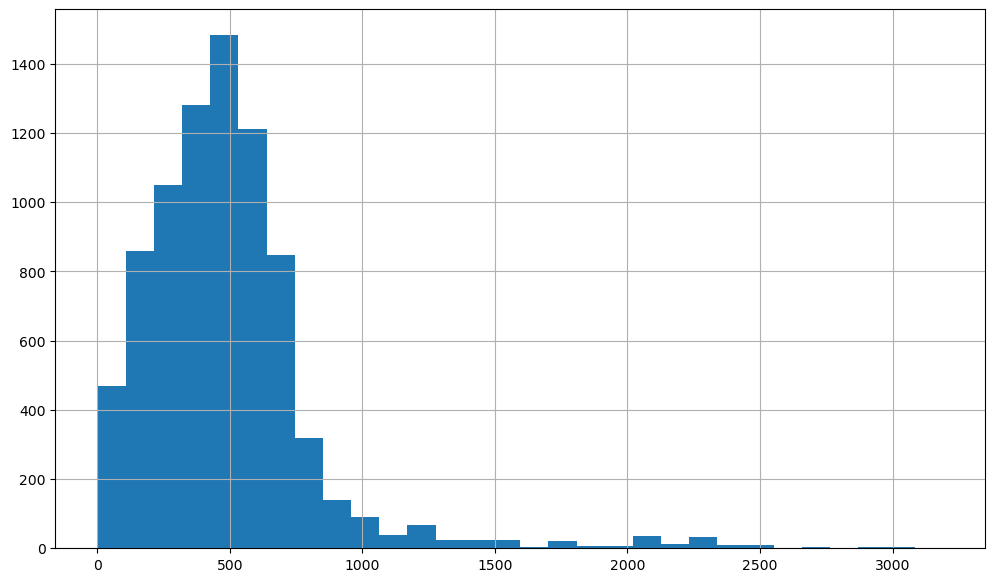

In [16]:
#строим гистограмму для столбца parks_nearest
estate_data.parks_nearest.hist(bins=30, figsize=(12, 7));

По большей части парки находятся в пределах километра от дома. Остальное - реже.

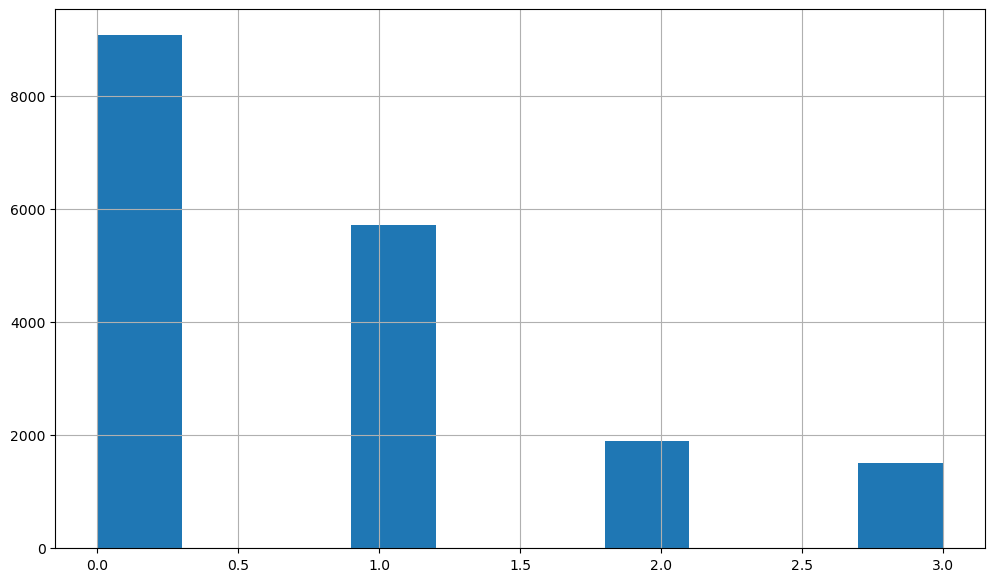

In [17]:
#строим гистограмму для столбца ponds_around3000
estate_data.ponds_around3000.hist(figsize=(12, 7));

Похоже на распределение парков, но прудов всё же больше парков и встречаются они чаще.

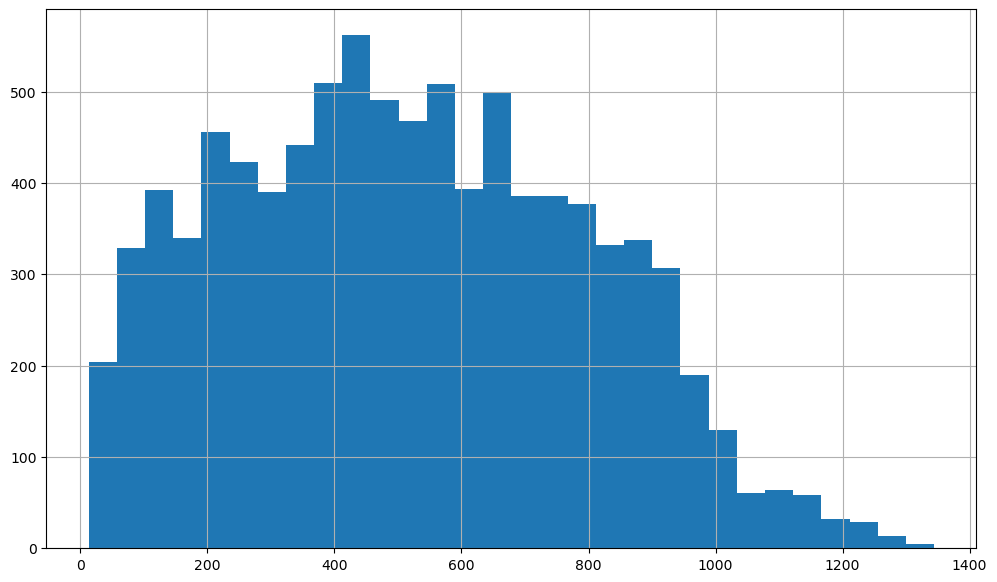

In [18]:
#строим гистограмму для столбца ponds_nearest
estate_data.ponds_nearest.hist(bins=30, figsize=(12, 7));

Если пруд есть, он скорее всего будет в предалах километра от дома. В более редких случаях - до 1.4 километра.

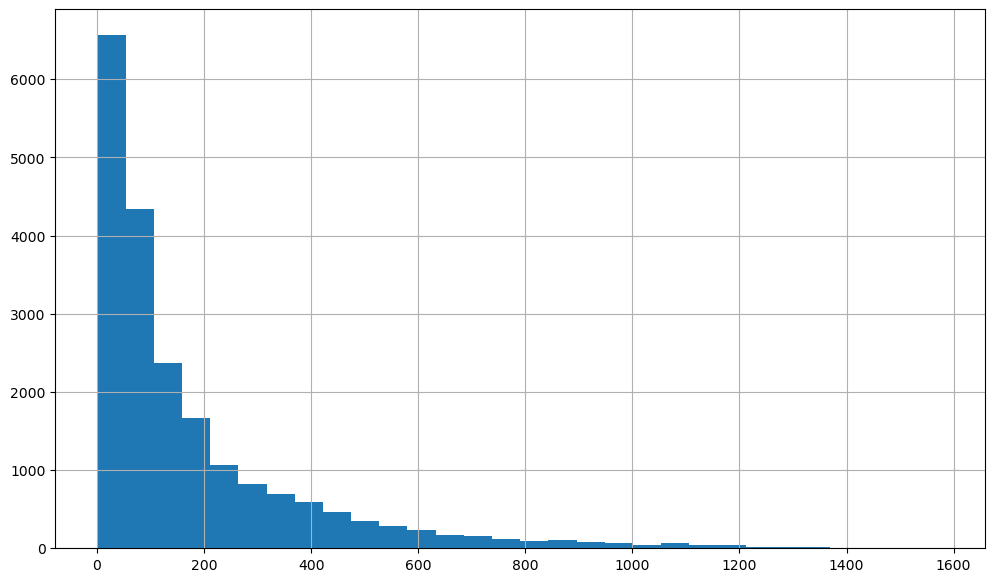

In [19]:
#строим гистограмму для столбца days_exposition
estate_data.days_exposition.hist(bins=30, figsize=(12, 7));

График выглядит нормально, но надо будет в процессе посмотреть более подробно не небольшие значения - 0...200 или может 0...400, чтобы удостовериться в отсутсутвии каких либо сюрпризов. 

### Предобработка данных

In [20]:
#проверяем типы данных и названия столбцов
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Можно сделать первые выводы по типам данных и по пробелам в данных. Что напрашивается:
1. **Привести все названия к "змеиному" стилю.**
2. **Обнаружено очень много пробелов в данных:**
   - в столбце ceiling_height примерно 9000 значений
   - в столбце floors_total примерно 86 значений
   - в столбце living_area примерно 1900 значений
   - в столбце is_apartment примерно 20900 значений и внимание тип столбца не булев, а строка.
   - в столбце kitchen_area примерно 2200 значений
   - в столбце balcony примерно 11500 значений
   - в столбце locality_name примерно 50 значений, но это может быть очень неприятно, если исследовать взаимосвязь места (города, посёлка) и цены на метр квадратный там
   - в столбце airports_nearest примерно 5500 значений
   - в столбце cityCenters_nearest примерно 5500 значений
   - в столбце parks_around3000 примерно 5500 значений
   - в столбце ponds_around3000 примерно 5500 значений
   - в столбце parks_nearest примерно 15600 значений
   - в столбце ponds_nearest примерно 14500 значений
   - в столбце days_exposition примерно 3100 значений
3. **Столбец first_day_exposition нужно привести к типу дата-время и округлить его до дня размещения (часы, минуты, секунды там особо ни на что не влияют)**
4. **Нужно проверить строки на наличие дубликатов ,и если таковые имеются, удалить их.**

#### Приведение столбцов к змеиному стилю

In [21]:
#перименовываем столбцы в змеином стиле
estate_data.rename(
    columns={'cityCenters_nearest': 'city_centers_nearest',
             'parks_around3000': 'parks_around_3000', 'ponds_around3000': 'ponds_around_3000'}
    , inplace=True
)
#проверка переименования
estate_data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

#### Проверка на дубликаты и их удаление

In [22]:
#считаем дубликаты (явные)
estate_data.duplicated().sum()

0

In [23]:
#поиск неявных дубликатов - они могут возникнуть только из-за столбца locality_name
#смотрим  количество уникальных названий
print(estate_data.sort_values(by="locality_name").locality_name.unique())
print(estate_data.locality_name.nunique())

['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Свирьстрой'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатово' 'деревня Аро'
 'деревня Батово' 'деревня Бегуницы' 'деревн

In [24]:
#проверка количества населённых пунктов после преобразования
estate_data['locality_name'] = estate_data['locality_name'].str.lower().str.replace('ё', 'е').str.replace('городского типа ', '')
print(estate_data.locality_name.nunique())

329


In [25]:
#повторная проверка на дубликаты
estate_data.duplicated().sum()

0

Дубликатов нет. Но, проверить, в любом случае, надо было.

#### Приведение столбцов к типам данных

In [26]:
#приводим столбец first_day_exposition к datetime
estate_data['first_day_exposition'] = pd.to_datetime(estate_data.first_day_exposition, format='%Y-%m-%dT%H:%M:%S')
estate_data['first_day_exposition'] = estate_data['first_day_exposition'].dt.floor('1d')
#проверка успешности перехода к новому типу столбца
estate_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [27]:
#столбец is_apartment приводим к типу bool
estate_data.is_apartment.unique()

array([nan, False, True], dtype=object)

In [28]:
#смотрим примеры апартаментов
estate_data.query("is_apartment == True")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
543,11,12790000.0,56.60,2018-11-06,2,3.50,3.0,29.400000,1,True,...,NaN,NaN,петергоф,35248.0,30437.0,3.0,53.0,3.0,22.0,NaN
916,11,8183000.0,70.00,2018-01-11,2,3.12,3.0,40.000000,3,True,...,NaN,2.0,санкт-петербург,45796.0,21729.0,0.0,NaN,1.0,754.0,179.0
1109,1,34878556.0,95.80,2014-12-09,2,NaN,6.0,58.300000,5,True,...,20.00,1.0,санкт-петербург,21860.0,318.0,2.0,160.0,3.0,569.0,1572.0
1608,12,2150000.0,20.10,2019-01-30,1,NaN,9.0,NaN,1,True,...,NaN,NaN,санкт-петербург,26646.0,12147.0,0.0,NaN,0.0,NaN,13.0
2759,11,7500000.0,152.00,2018-07-27,3,3.00,3.0,NaN,1,True,...,NaN,1.0,всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2975,9,4931398.0,42.90,2018-07-23,1,3.15,4.0,20.390000,3,True,...,10.29,NaN,санкт-петербург,44870.0,20802.0,0.0,NaN,1.0,792.0,273.0
3067,13,6600000.0,95.00,2018-09-08,2,4.50,7.0,45.000000,7,True,...,25.00,2.0,выборг,NaN,NaN,NaN,NaN,NaN,NaN,96.0
3816,4,4779000.0,53.10,2016-05-16,1,NaN,13.0,19.800000,6,True,...,15.90,2.0,санкт-петербург,19396.0,4516.0,0.0,NaN,1.0,826.0,60.0
3951,10,4300000.0,50.00,2019-04-20,1,3.00,11.0,17.000000,9,True,...,12.00,2.0,санкт-петербург,10143.0,11367.0,0.0,NaN,0.0,NaN,NaN
4339,19,6900000.0,72.00,2019-03-25,3,3.50,4.0,70.000000,1,True,...,NaN,NaN,санкт-петербург,31487.0,4466.0,2.0,353.0,1.0,439.0,22.0


Предварительный вывод: апартаментов очень мало. По какому принципу их выделяли не ясно - встречаются среди них как комнатушки - студии с 20 метрами площади всего, так и гиганские квартиры на 500 метров. Поэтому все отсутствующие значения можно смело ставить False и данных не терять.

In [29]:
#преобразуем столбец is_apartment к типу bool
estate_data.is_apartment.fillna(False, inplace=True)

#сократим память,где можем
estate_data['floor'] = estate_data['floor'].astype('int32')
estate_data['total_images'] = estate_data['total_images'].astype('int32')
estate_data['rooms'] = estate_data['rooms'].astype('int32')
estate_data['floors_total'] = estate_data['floors_total'].astype('float32')
estate_data['total_area'] = estate_data['total_area'].astype('float32')
estate_data['ceiling_height'] = estate_data['ceiling_height'].astype('float32')
estate_data['living_area'] = estate_data['living_area'].astype('float32')
estate_data['kitchen_area'] = estate_data['kitchen_area'].astype('float32')
estate_data['balcony'] = estate_data['balcony'].astype('float32')
estate_data['parks_around_3000'] = estate_data['parks_around_3000'].astype('float32')
estate_data['ponds_around_3000'] = estate_data['ponds_around_3000'].astype('float32')
estate_data['days_exposition'] = estate_data['days_exposition'].astype('float32')

#проверяем успешность преобразования
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int32         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float32       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int32         
 5   ceiling_height        14504 non-null  float32       
 6   floors_total          23613 non-null  float32       
 7   living_area           21796 non-null  float32       
 8   floor                 23699 non-null  int32         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float32       
 13  balcony         

#### Заполнение пустых значений численных столбцов

In [30]:
#количество строк до предобработки данных
shape_before = estate_data.shape
shape_before

(23699, 22)

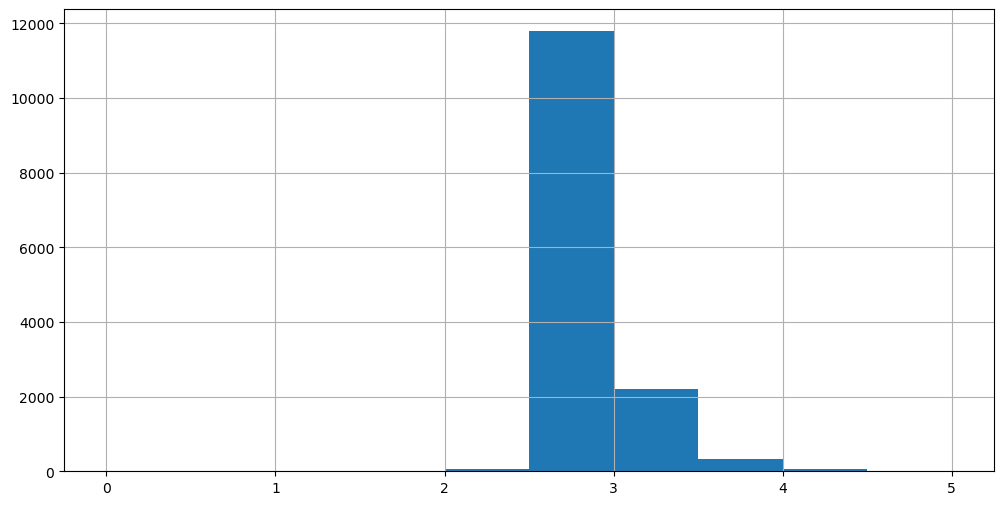

In [31]:
#смотрим столбец ceiling_height
estate_data.ceiling_height.hist(range=(0, 5), figsize=(12, 6));

In [32]:
#выводим неправдоподобно высокие потолки
estate_data.ceiling_height.sort_values(ascending=False).head(30)

22869    100.0
22336     32.0
3148      32.0
21377     27.5
20478     27.0
5246      27.0
5807      27.0
10773     27.0
17857     27.0
22938     27.0
21824     27.0
4876      27.0
5669      26.0
18545     25.0
11285     25.0
355       25.0
6246      25.0
14382     25.0
4643      25.0
9379      25.0
5076      24.0
20507     22.6
17496     20.0
15061     14.0
22309     10.3
5863       8.3
15743      8.0
3474       8.0
17442      8.0
20264      6.0
Name: ceiling_height, dtype: float32

In [33]:
#квартиры с неправдоподобно высокими потолками, где высота потолков явно подлежит замене
estate_data.query('ceiling_height >= 8')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
355,17,3600000.0,55.200001,2018-07-12,2,25.0,5.0,32.000000,2,False,...,NaN,2.0,гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.000000,2018-11-12,3,32.0,3.0,53.000000,2,False,...,8.0,NaN,волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,3,1400000.0,30.000000,2018-03-16,1,8.0,5.0,15.300000,2,False,...,7.3,NaN,деревня нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
4643,0,4300000.0,45.000000,2018-02-01,2,25.0,9.0,30.000000,2,False,...,7.0,1.0,санкт-петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.000000,2017-09-27,0,27.0,25.0,17.000000,17,False,...,NaN,2.0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.500000,2018-10-03,1,24.0,5.0,19.500000,1,True,...,5.5,NaN,санкт-петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.000000,2017-10-13,2,27.0,5.0,30.000000,3,False,...,9.0,2.0,деревня мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000.0,50.000000,2017-08-08,2,26.0,9.0,21.299999,3,False,...,7.0,2.0,санкт-петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.000000,2019-01-09,2,27.0,36.0,41.000000,13,False,...,12.0,5.0,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
5863,20,5650000.0,45.000000,2018-08-15,1,8.3,16.0,19.299999,14,False,...,8.3,1.0,санкт-петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0


Надо смотреть дальше. Помимо основной массы потолков, которая должна быть до 5-6 метров максимум, есть несколько значений которые идут в разрез со здравым смыслом (высота потолков от 20 до 100 метров - звучит неправдоподобно). Данные это подтверждают. 100 метров - явный перебор, но и в 10 - не вериться. Все значения от 20 до 32 метров будем делить на 10, а остальные выдающиеся от 8 метров - заменим на медиану.

In [34]:
#считаем медианную высоту потоков 
median_ceiling_height = estate_data.ceiling_height.median()
print(median_ceiling_height)

#заменяем пустые значения в столбце ceiling_height медианой
estate_data.ceiling_height.fillna(median_ceiling_height, inplace=True)

#заменяем значения потолков от 20 до 32 метров - разделив их на 10, а остальные выдающиеся - на медианное значение.
def ceil_height(height):
    if (height >= 20) and (height < 33):
        return height / 10
    elif (height >= 8):
        return median_ceiling_height
    else:
        return height

estate_data['ceiling_height'] = estate_data['ceiling_height'].apply(ceil_height)

#проверяем успешность заполнения
estate_data.head(10)

2.6500000953674316


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,False,...,25.00,NaN,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,False,...,11.00,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,False,...,8.30,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14.0,NaN,9,False,...,NaN,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,False,...,41.00,NaN,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,False,...,9.10,NaN,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.299999,2017-11-02,1,2.65,26.0,10.600000,6,False,...,14.40,1.0,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.599998,2019-04-18,2,2.65,24.0,NaN,22,False,...,18.90,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.160000,2018-05-23,1,2.65,27.0,15.430000,26,False,...,8.81,NaN,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9.0,43.599998,7,False,...,6.50,2.0,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [35]:
# выводим все оставшиеся значения высоты потолка на экран
estate_data['ceiling_height'].unique()

array([2.70000005, 2.6500001 , 3.02999997, 2.5       , 2.67000008,
       2.55999994, 3.04999995, 2.75      , 2.5999999 , 2.9000001 ,
       2.79999995, 2.54999995, 3.        , 3.20000005, 2.6099999 ,
       3.25      , 3.45000005, 2.76999998, 2.8499999 , 2.6400001 ,
       2.56999993, 4.1500001 , 3.5       , 3.29999995, 2.71000004,
       4.        , 2.47000003, 2.73000002, 2.83999991, 3.0999999 ,
       2.33999991, 3.4000001 , 3.05999994, 2.72000003, 2.53999996,
       2.50999999, 2.77999997, 2.75999999, 2.57999992, 3.70000005,
       2.51999998, 5.19999981, 2.86999989, 2.66000009, 2.58999991,
       2.        , 2.45000005, 3.5999999 , 2.92000008, 3.1099999 ,
       3.13000011, 3.79999995, 3.1500001 , 3.54999995, 3.16000009,
       3.61999989, 3.11999989, 2.52999997, 2.74000001, 2.96000004,
       2.46000004, 5.30000019, 5.        , 2.78999996, 2.95000005,
       4.05999994, 2.94000006, 3.81999993, 3.53999996, 3.52999997,
       2.82999992, 4.69999981, 2.4000001 , 3.38000011, 3.00999

count    23613.000000
mean        10.673823
std          6.597260
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


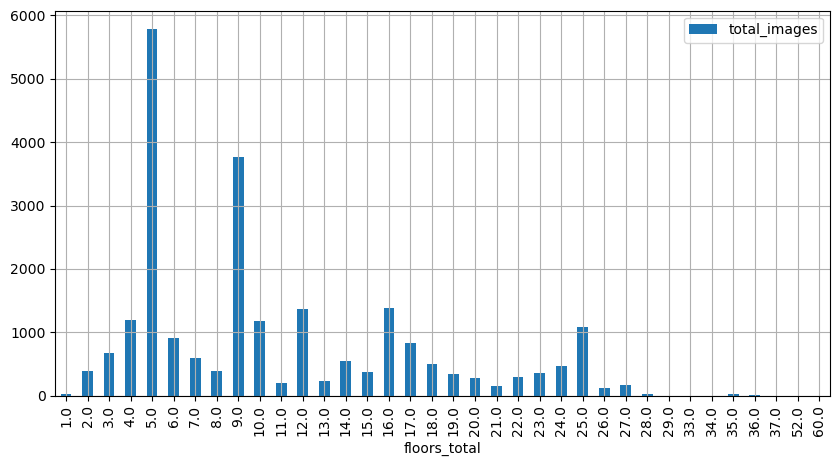

In [36]:
#исследуем столбец floors_total
estate_data.groupby('floors_total', as_index=False).count().plot(x='floors_total', y='total_images', kind='bar', figsize=(10, 5), grid=True)
print(estate_data.floors_total.describe())

Видны явно 2 пика: у нас много 5 и 9 этажек. Достаточно распостранены 12, 16, 10, 25 и 4 этажные дома. В среднем у нас приблизительно 11 этажные дома, медиана на 9 этажках. Заполнять будем пропуски с учётом этажности квартиры, если квартира выше 10 этажа - вернём этажность дома, как этаж на котором находится эта квартира, если нет - то по среднему.

In [37]:
#заполняем пропуски столбца floors_total
def floors_in_house(row):
    if row['floor'] != np.nan and row['floor'] > 10:
        return row['floor']
    elif row['floor'] != np.nan and row['floor'] <= 10: 
        return 10

estate_data.loc[estate_data.floors_total.isna(), 'floors_total'] = estate_data.apply(floors_in_house, axis=1)
#проверяем успешность заполнения
estate_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,False,...,25.0,NaN,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11.0,18.600000,1,False,...,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5.0,34.299999,4,False,...,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14.0,NaN,9,False,...,NaN,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,False,...,41.0,NaN,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [38]:
#меняем тип столбца floors_total на int
estate_data['floors_total'] = estate_data.floors_total.astype('int32')
estate_data['ceiling_height'] = estate_data.ceiling_height.astype('float32')
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int32         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float32       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int32         
 5   ceiling_height        23699 non-null  float32       
 6   floors_total          23699 non-null  int32         
 7   living_area           21796 non-null  float32       
 8   floor                 23699 non-null  int32         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float32       
 13  balcony         

Далее, жилая площадь в квартире очень сильно зависит от общей площади квартиры - и раз последняя везде нам известна, то мы можем рассчитать соотношение жилой площади к общей и усреднить его. Далее, мы получим коэффициент на который надо умножить для реалистичной оценки жилой площади в квартирах, где она не указана.

In [39]:
#разделим и посмотрим как меняется коэффициент жилой площади и площади кухни в зависимости от количества комнат
coef_living_area = estate_data.groupby('rooms').agg({'total_area': 'sum', 'living_area': 'sum', 'kitchen_area': 'sum'})
l_area = coef_living_area.living_area / coef_living_area.total_area
k_area = coef_living_area.kitchen_area / coef_living_area.total_area
print(l_area, k_area, l_area + k_area, sep='\n\n')

rooms
0     0.598522
1     0.436401
2     0.522114
3     0.562421
4     0.574455
5     0.554754
6     0.612783
7     0.553775
8     0.650701
9     0.544080
10    0.637858
11    0.708841
12    0.455222
14    0.641519
15    0.693220
16    0.666667
19    0.706086
dtype: float32

rooms
0     0.000000
1     0.227398
2     0.163953
3     0.134565
4     0.116323
5     0.099443
6     0.096483
7     0.073073
8     0.071943
9     0.071697
10    0.088096
11    0.066702
12    0.124444
14    0.069855
15    0.169492
16    0.048148
19    0.073679
dtype: float32

rooms
0     0.598522
1     0.663800
2     0.686067
3     0.696987
4     0.690779
5     0.654198
6     0.709267
7     0.626848
8     0.722644
9     0.615777
10    0.725953
11    0.775543
12    0.579667
14    0.711374
15    0.862712
16    0.714815
19    0.779765
dtype: float32


Первая особенность:у квартир с 0 комнатами (это квартиры - студии) нет площади кухни и заменять её нужно нолём.

In [40]:
#находим среднее отношение жилой площади в квартире к общей площади квартиры
mean_coef_living_area = (estate_data.living_area / estate_data.total_area).mean()
mean_coef_living_area

0.5647656

In [41]:
#заполняем засчёт найденных коэффициентов пустые значения в столце living_area
for room in l_area.index:
    estate_data.loc[estate_data.rooms == room, 'living_area'] = (
        estate_data.query('rooms == @room').living_area.fillna((estate_data.query('rooms == @room').total_area * l_area[room]).round(1))
    )

#проверяем успешность заполнения новыми значениями столбца living_area
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,25.00,NaN,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,11.00,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,8.30,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,NaN,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,41.00,NaN,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,...,9.10,NaN,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,...,14.40,1.0,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.599998,2019-04-18,2,2.65,24,37.400002,22,False,...,18.90,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.160000,2018-05-23,1,2.65,27,15.430000,26,False,...,8.81,NaN,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,...,6.50,2.0,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Заполним по аналогии с жилой площадью заполнить площадь кухни, там где её нет. 

In [42]:
#находим среднее отношение площади кухни в квартире к общей площади квартиры
mean_coef_kitchen_area = (estate_data.kitchen_area / estate_data.total_area).mean()
mean_coef_kitchen_area

0.18735473

In [43]:
#заполняем засчёт найденных коэффициентов пустые значения в столце kitchen_area
for room in k_area.index:
    estate_data.loc[estate_data.rooms == room, 'kitchen_area'] = estate_data.query('rooms == @room').kitchen_area.fillna(estate_data.query('rooms == @room').total_area * k_area[room]).round(1)
    
#проверяем успешность заполнения новыми значениями столбца kitchen_area
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,25.0,NaN,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,21.4,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,41.0,NaN,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,...,9.1,NaN,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,...,14.4,1.0,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.599998,2019-04-18,2,2.65,24,37.400002,22,False,...,18.9,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.160000,2018-05-23,1,2.65,27,15.430000,26,False,...,8.8,NaN,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,...,6.5,2.0,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


В данных есть проблемы даже при таком заполнении (да и без него тоже были) - в некоторых строках жилая площадь + площадь кухни оказывается даже больше, чем площадь всей квартиры! Как исправить этот недостаток неясно, но таких данных относительно немного.

<Axes: >

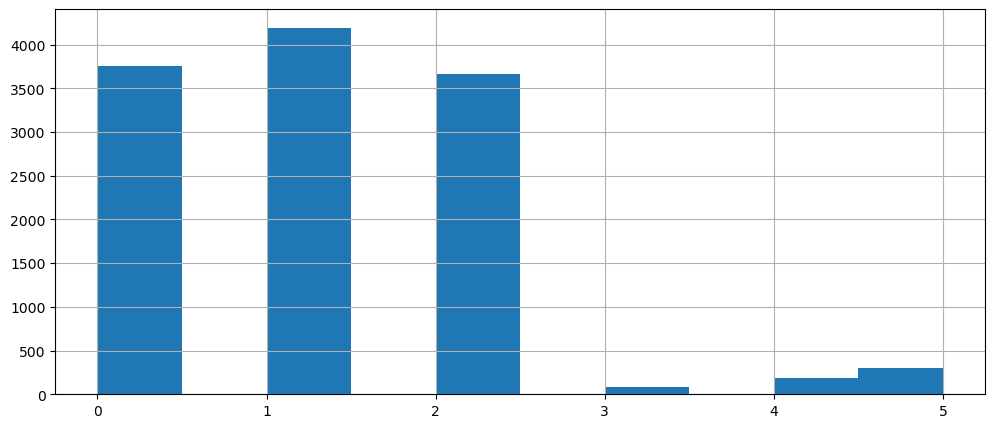

In [44]:
#смотрим на столбец balcony
estate_data.balcony.hist(figsize=(12, 5))

В большинстве квартир 1 балкон. Достаточно часто балконов не встречается вообще и чуть реже встречается 2 балкона. 3 и более балконов - относительная редкость. Есть идея проверить как связана этаж, где находиться квартира с количеством балконов. Гипотеза: на 1 этаже балконов будет мало, а вот со 2го - гораздо больше.

In [45]:
estate_data.groupby('floor').agg({'balcony': ['count', 'sum']})

balcony        
        count     sum
floor                
1         991   704.0
2        1589  1533.0
3        1557  1646.0
4        1448  1530.0
5        1383  1515.0
6         712   928.0
7         710   896.0
8         612   843.0
9         639   797.0
10        405   551.0
11        307   440.0
12        319   443.0
13        230   315.0
14        196   276.0
15        220   333.0
16        177   248.0
17        126   170.0
18        104   169.0
19         91   124.0
20         74   119.0
21         75   102.0
22         63    96.0
23         60    81.0
24         40    71.0
25         25    34.0
26         18    31.0
27          5     8.0
28          1     1.0
29          1     2.0
30          0     0.0
31          0     0.0
32          1     0.0
33          1     2.0

Гипотеза верна только частично: действительно, на первом этаже балконов меньше, чем на остальных, но судя по этим данным даже на первом этаже есть балкон более чем в половине случаев, на втором этаже есть с 95% вероятностью, а выше страчаются и с 2 балконами квартиры. Но раз сами продавцы не указали его наличие (с допуском на то, что данные не были утеряны) - то все пропуски заменим на 0 (балконов нет).

In [46]:
#заменяем пропуски в столбце balcony на 0
estate_data.balcony.fillna(0, inplace=True)

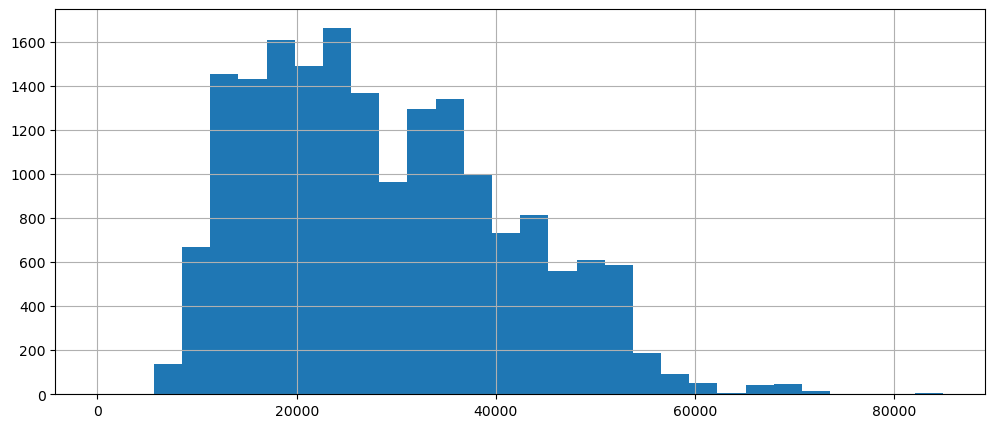

In [47]:
#исследование по столбцу airports_nearest
estate_data.airports_nearest.hist(bins=30, figsize=(12, 5));

Основная часть квартир находиться на расстоянии 20 - 40 километров от аэропорта. 95% квартир находиться в пределах 60 километров от аэропорта. Самые отдалённые - более 80 километров от аэропорта. Есть идея, что отдалённость от аэропорта зависит от населённого пункта. Проверим это. Если это так, то заполним пропуски в этом стобце - медианой расстояния до аэропорта в данном населённом пункте.

In [48]:
#расстояние до аэропорта в разрезе населённых пунктов
median_distance_to_airport = estate_data.pivot_table(index='locality_name', values='airports_nearest', aggfunc='median')
median_distance_to_airport

,airports_nearest
locality_name,
зеленогорск,72282.0
колпино,26232.0
красное село,25715.5
кронштадт,67850.0
ломоносов,48415.5
павловск,20529.5
петергоф,39231.0
поселок александровская,12896.5
поселок белоостров,57769.0


In [49]:
#заполняем данные столбца airports_nearest
for sity in median_distance_to_airport.index:
    estate_data.loc[estate_data.locality_name == sity, 'airports_nearest'] = estate_data.query('locality_name == @sity').airports_nearest.fillna(median_distance_to_airport.loc[sity])
    
#проверяем успешность заполнения новыми значениями столбца airports_nearest
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,25.0,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,21.4,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,41.0,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,...,9.1,0.0,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,...,14.4,1.0,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.599998,2019-04-18,2,2.65,24,37.400002,22,False,...,18.9,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.160000,2018-05-23,1,2.65,27,15.430000,26,False,...,8.8,0.0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,...,6.5,2.0,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


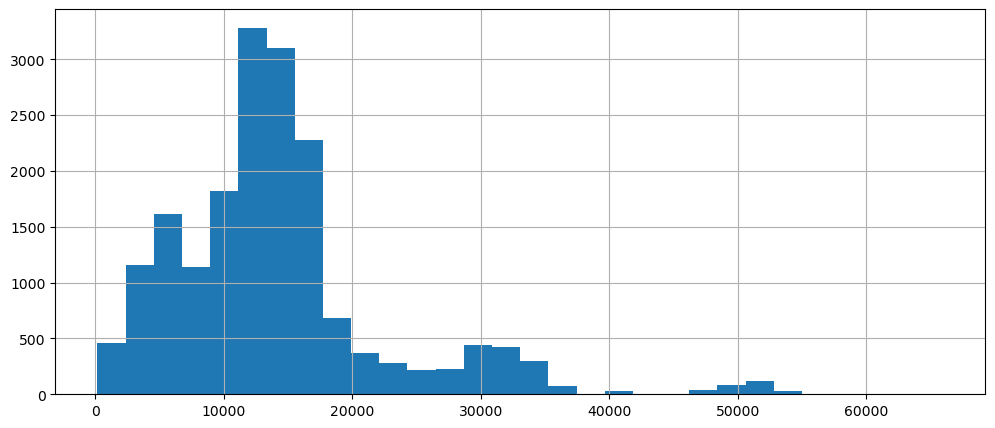

In [50]:
#ислледование по столбцу city_centers_nearest
estate_data.city_centers_nearest.hist(bins=30, figsize=(12, 5));

Пик значений приходится примерно на 12 километров от центра города. 95% квартир находятся в пределах 35 километров от центра города. Отдельные квартиры дальше 60 километров от центра города. Но заполнять пропуски в этом столбце лучше всего по населённым пунктам (медианным значением) - так ошибка будет меньше всего.

In [51]:
#расстояние до центра города в разрезе населённых пунктов
median_distance_to_center = estate_data.pivot_table(index='locality_name', values='city_centers_nearest', aggfunc='median')
median_distance_to_center

,city_centers_nearest
locality_name,
зеленогорск,53381.0
колпино,32018.0
красное село,29140.5
кронштадт,49575.0
ломоносов,51677.0
павловск,32683.0
петергоф,33771.0
поселок александровская,27468.0
поселок белоостров,38868.0


In [52]:
#заполняем данные столбца city_centers_nearest
for sity in median_distance_to_airport.index:
    estate_data.loc[estate_data.locality_name == sity, 'city_centers_nearest'] = estate_data.query('locality_name == @sity').city_centers_nearest.fillna(median_distance_to_center.loc[sity])
    
#проверяем успешность заполнения новыми значениями столбца city_centers_nearest
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,25.0,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,21.4,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,41.0,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,...,9.1,0.0,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,...,14.4,1.0,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.599998,2019-04-18,2,2.65,24,37.400002,22,False,...,18.9,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.160000,2018-05-23,1,2.65,27,15.430000,26,False,...,8.8,0.0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,...,6.5,2.0,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


count    18181.000000
mean         0.611408
std          0.802124
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around_3000, dtype: float64

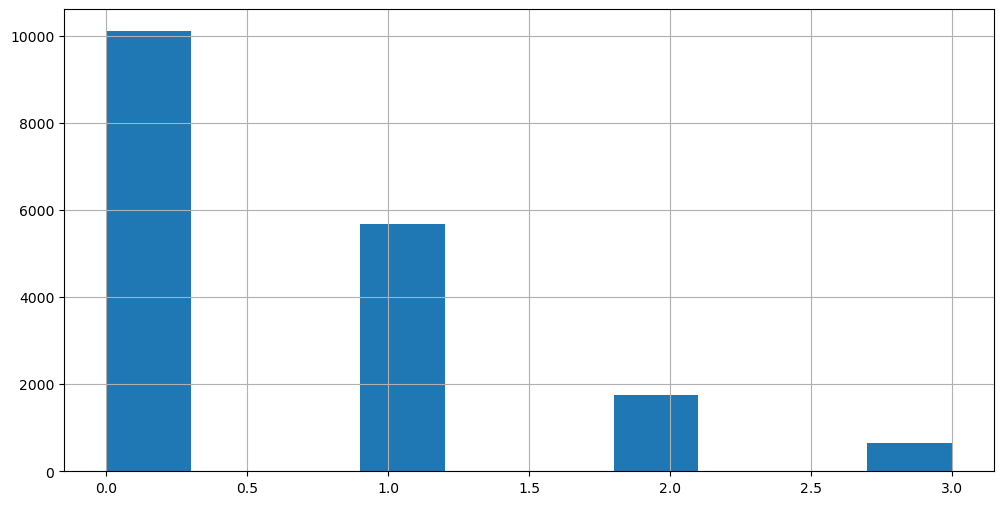

In [53]:
#исследуем значения столбца parks_around_3000
estate_data.parks_around_3000.hist(figsize=(12, 6));
estate_data.parks_around_3000.describe()

Как и ожидалось: парков не очень много в принципе. И их количество рядом - 3 максимум. Медиана - 0. Разброс велик. Заполнять пропущенные значения можно только в тех населённых пунктах, про которые мы может получить статистику. Если не можем - заполнять не будем - из-за риска получить некорректные данные.  Да и ещё один момент - для дальнейшего анализа этот столбец нам не потребуется. Это скорее некоторое субъективное преимещество для тех, кто живёт в начелённых пунктах, где рядом есть парки.

In [54]:
#исследуем взаимосвязь количества парков в 3 километрах и населённого пункта.
number_parks = estate_data.pivot_table(index='locality_name', values='parks_around_3000', aggfunc='median')
number_parks = number_parks.query('parks_around_3000 != 0')
number_parks

,parks_around_3000
locality_name,
зеленогорск,3.0
кронштадт,2.0
павловск,2.0
петергоф,1.0
пушкин,1.0


In [55]:
#заполняем пропуски столбца parks_around_3000
for sity in number_parks.index:
    estate_data.loc[estate_data.locality_name == sity, 'parks_around_3000'] = (
        estate_data.query('locality_name == @sity').parks_around_3000.fillna(number_parks.loc[sity])
    )

#проверяем заполнение столбца parks_around_3000
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,25.0,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,21.4,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,41.0,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,...,9.1,0.0,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,...,14.4,1.0,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.599998,2019-04-18,2,2.65,24,37.400002,22,False,...,18.9,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.160000,2018-05-23,1,2.65,27,15.430000,26,False,...,8.8,0.0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,...,6.5,2.0,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

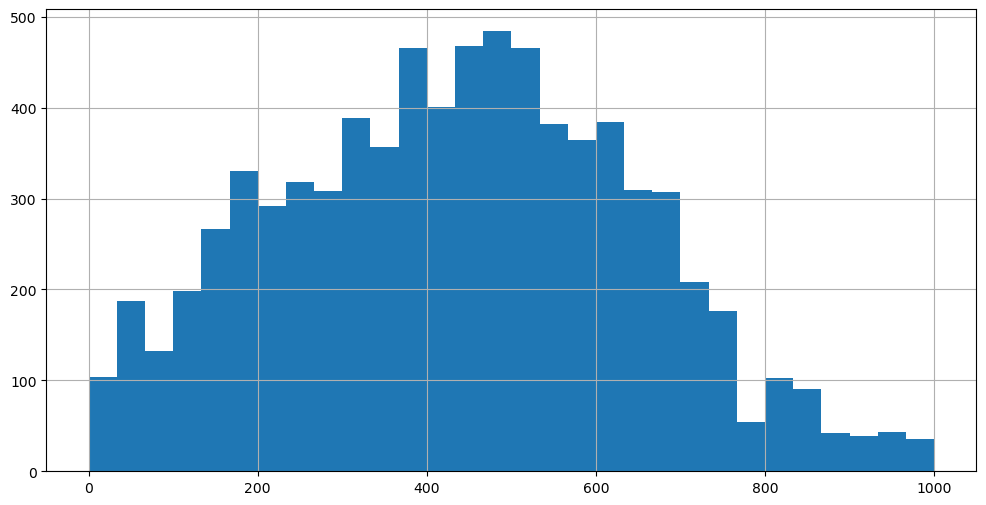

In [56]:
#исследуем столбец parks_nearest
estate_data.parks_nearest.hist(bins=30, figsize=(12, 6), range=(0, 1000));
estate_data.parks_nearest.describe()

Большинство квартир находится в пределах 1 километра от парков. в худших случаях - в пределах 3 км, но эти значения уже очень редки. на самом деле создаётся впечатление, что уже после 1 километра эти значения можно не смотреть. Может, разрез по населённым пунктам покажет несколько иную картину? Также важно заметить - этих данных явно мало - они присуствуют только в 1/3 данных, распостранять на всю выборку без учёта населённого пункта такие значения нельзя.

In [57]:
#расстояние до ближайшего парка в разрезе населённых пунктов
median_distance_to_park = estate_data.pivot_table(index='locality_name', values='parks_nearest', aggfunc='median')
median_distance_to_park

,parks_nearest
locality_name,
зеленогорск,147.5
колпино,393.0
красное село,428.5
кронштадт,293.0
ломоносов,407.0
павловск,312.0
петергоф,294.0
поселок парголово,733.0
поселок стрельна,700.0


Ничего принципиально нового не добавло это разделение. Пускай и далеко не всем можно согласиться - данные для добаления в столбец с пустыми значениями есть. Но если прямо указано, что парков в 3 километрах нет, заполнять этот столбец не имеет смысла, так что проверяем условия и ставим, где этого не сказано.

In [58]:
#заполняем значения столбца parks_nearest
for sity in median_distance_to_park.index:
    estate_data.loc[(estate_data.locality_name == sity) & (estate_data.parks_around_3000 != 0), 'parks_nearest'] = (
        estate_data.query('locality_name == @sity & parks_around_3000 != 0').parks_nearest.fillna(median_distance_to_park.loc[sity])
    )

#проверяем заполнение столбца parks_nearest
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,25.0,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,21.4,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,41.0,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,...,9.1,0.0,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,...,14.4,1.0,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.599998,2019-04-18,2,2.65,24,37.400002,22,False,...,18.9,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.160000,2018-05-23,1,2.65,27,15.430000,26,False,...,8.8,0.0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,...,6.5,2.0,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


count    18181.000000
mean         0.770255
std          0.938399
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around_3000, dtype: float64

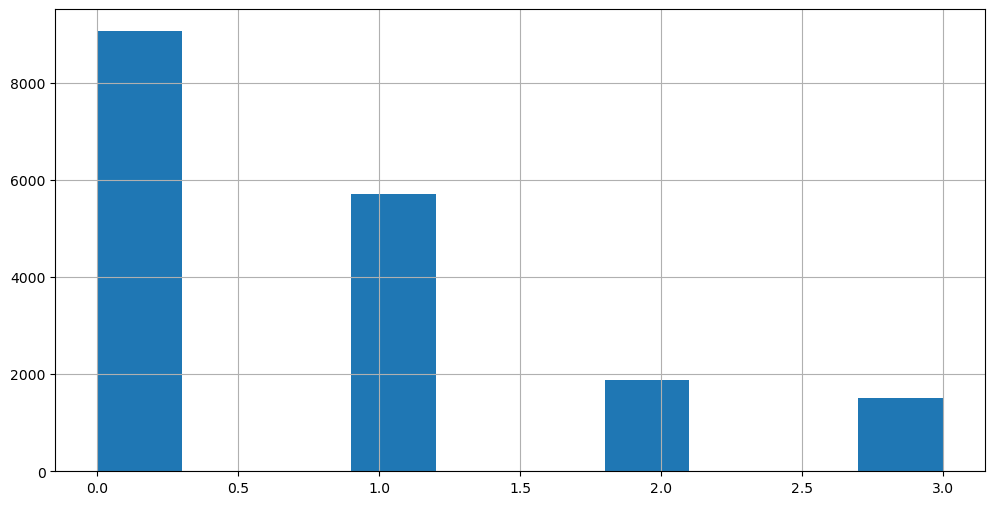

In [59]:
#исследуем столбец ponds_around_3000
estate_data.ponds_around_3000.hist(figsize=(12, 6));
estate_data.ponds_around_3000.describe()

Ситуация с прудами в предах 3 километров во многом повторяет ситуацию с парками. Но есть отличия: тут уже медиана - 1. А вот графики - просто близнецы. Опять же полезно посмотреть в разрезе населённых пунктов - может будут отличия от общих тенденций!? Заполнять можно только в тех населённых пунктах, где есть информация про них. Если её нет - заполянять не будем. Опять же в дальнейшем исследовании этот столбец не будет играть роли.

In [60]:
#исследуем взаимосвязь количества прудов в 3 километрах и населённого пункта
number_ponds = estate_data.pivot_table(index='locality_name', values='ponds_around_3000', aggfunc='median')
number_ponds

,ponds_around_3000
locality_name,
зеленогорск,1.0
колпино,1.0
красное село,0.0
кронштадт,2.0
ломоносов,1.0
павловск,2.0
петергоф,1.0
поселок александровская,1.0
поселок белоостров,1.0


Вот и отличия. Есть пункты с большим количеством прудов, чем по медиане. Заполнять будем значениями из списка.

In [61]:
#заполняем пропущенные значения столбца ponds_around_3000
for sity in number_ponds.index:
    estate_data.loc[estate_data.locality_name == sity, 'ponds_around_3000'] = estate_data.query('locality_name == @sity').ponds_around_3000.fillna(number_ponds.loc[sity])

#проверяем заполнение столбца ponds_around_3000
estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,25.0,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,21.4,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,41.0,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12,14.400000,5,False,...,9.1,0.0,городской поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.299999,2017-11-02,1,2.65,26,10.600000,6,False,...,14.4,1.0,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.599998,2019-04-18,2,2.65,24,37.400002,22,False,...,18.9,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.160000,2018-05-23,1,2.65,27,15.430000,26,False,...,8.8,0.0,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9,43.599998,7,False,...,6.5,2.0,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

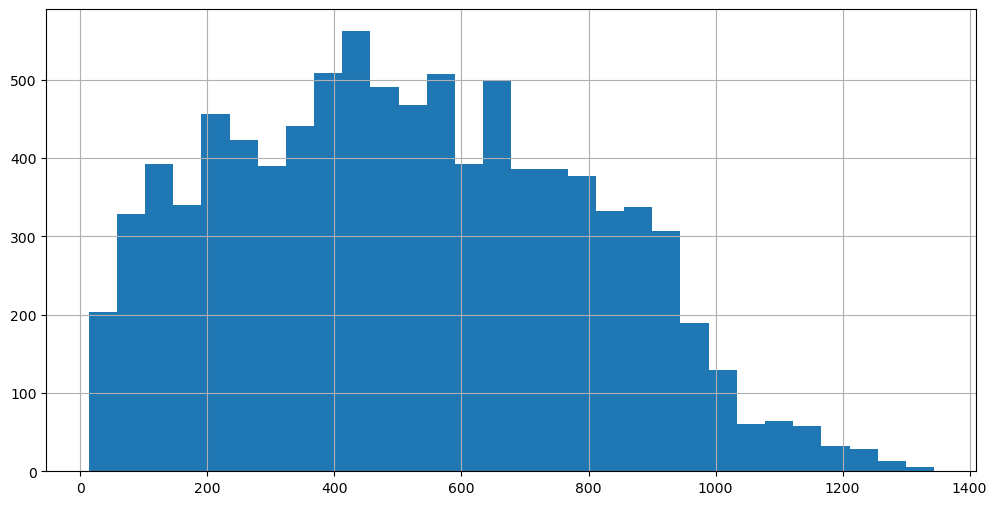

In [62]:
#исследуем столбец ponds_nearest
estate_data.ponds_nearest.hist(bins=30, figsize=(12, 6));
estate_data.ponds_nearest.describe()

Проблем с имеющимися данными нет в этом столбце нет. Распределение нормальное об этом говорит и небольшая разница между средним и медианой в этом столбце. Можно рассмотреть данные в разрезе населённых пунктов взять медианное значение для тех, что будут и заполнить возможные пропуски. Как всегда важно не забыть, что там где нет прудов поблизости надо оставить пропуск.

In [63]:
#расстояние до ближайшего пруда в разрезе населённых пунктов
median_distance_to_ponds = estate_data.pivot_table(index='locality_name', values='ponds_nearest', aggfunc='median')
median_distance_to_ponds

,ponds_nearest
locality_name,
зеленогорск,507.0
колпино,509.0
красное село,225.5
кронштадт,312.0
ломоносов,553.0
павловск,458.0
петергоф,474.0
поселок александровская,711.5
поселок белоостров,320.0


In [64]:
#заполняем столбец ponds_nearest
for sity in median_distance_to_ponds.index:
    estate_data.loc[(estate_data.locality_name == sity) & (estate_data.ponds_around_3000 != 0), 'ponds_nearest'] = (
        estate_data.query('locality_name == @sity & ponds_around_3000 != 0').ponds_nearest.fillna(median_distance_to_ponds.loc[sity])
    )
#проверяем, что получилось
estate_data.tail(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
23689,13,3550000.0,35.299999,2018-02-28,1,2.86,15,16.299999,4,False,...,9.100000,2.0,санкт-петербург,17284.0,16081.0,1.0,353.0,2.0,652.0,29.0
23690,3,5500000.0,52.000000,2018-07-19,2,2.65,5,31.000000,2,False,...,6.000000,0.0,санкт-петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23691,11,9470000.0,72.900002,2016-10-13,2,2.75,25,40.299999,7,False,...,10.600000,1.0,санкт-петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0
23692,2,1350000.0,30.000000,2017-07-07,1,2.65,5,17.500000,4,False,...,6.000000,0.0,тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23693,9,4600000.0,62.400002,2016-08-05,3,2.60,9,40.000000,8,False,...,8.000000,0.0,петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5,73.300003,3,False,...,13.800000,0.0,санкт-петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.000000,2018-01-15,3,2.65,5,38.000000,4,False,...,8.500000,0.0,тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.700001,2018-02-11,2,2.65,3,29.700001,1,False,...,9.300000,0.0,село рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.750000,2017-03-28,2,3.00,17,40.099998,12,False,...,23.299999,2.0,санкт-петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.299999,2017-07-21,1,2.50,5,12.300000,1,False,...,9.000000,0.0,поселок новый учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Теперь пора удалять все найденные редкие значения.

In [65]:
#удаляем редкие и уникальные значения столбцов
estate_data = estate_data.query("total_images <= 34")
estate_data = estate_data.query('city_centers_nearest <= 55000 | city_centers_nearest.isna()')
estate_data = estate_data.query("total_area < 400")
estate_data = estate_data.query("living_area <= 200")
estate_data = estate_data.query("kitchen_area <= 63")
#estate_data = estate_data.query("floor <= 27")
estate_data = estate_data.query("floors_total <= 30")
estate_data = estate_data.query("rooms <= 9")

#количество данных после предобработки
shape_after = estate_data.shape
shape_after

(23580, 22)

In [66]:
#доля тех значений, которые остались после преобработки данных
print(f'{(shape_after[0] / shape_before[0]):.2%}')

99.50%


In [67]:
#смотрим на итог предобработки
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23580 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23580 non-null  int32         
 1   last_price            23580 non-null  float64       
 2   total_area            23580 non-null  float32       
 3   first_day_exposition  23580 non-null  datetime64[ns]
 4   rooms                 23580 non-null  int32         
 5   ceiling_height        23580 non-null  float32       
 6   floors_total          23580 non-null  int32         
 7   living_area           23580 non-null  float32       
 8   floor                 23580 non-null  int32         
 9   is_apartment          23580 non-null  bool          
 10  studio                23580 non-null  bool          
 11  open_plan             23580 non-null  bool          
 12  kitchen_area          23580 non-null  float32       
 13  balcony         

Вывод по преобработке: большинство значений заполнено. Столбцы airports_nearest, city_centers_nearest, parks_nearest, ponds_nearest заполнить новыми значениями отсюда не удалось. Из-за наличия пропусков тип float64 остался. Столбец days_exposition пропуски заполнять нельзя - это ещё не снятые с продажи квартиры на тот момент. Из-за них тип float64. В столбце locality_name удалены 35 неявных повторов, которые могли сказаться на дальнейшем анализе данных. В столбце ceiling_height (высота потолков в квартирах) заменены значения на более соотвествующие действительности. В результате удаления редких и уникальных значениях в столбцах мы оставили 99.5% датафрейма. Что в данном случае хорошо. Также из-за замены типов данных наш файл полегчал почти на 30%, что заметно.

## Посчитайте и добавьте в таблицу новые столбцы

In [68]:
#добавляем столбец цена квадратного метра (price_square_meter)
estate_data['price_square_meter'] = (estate_data.last_price / estate_data.total_area).round(2)

In [69]:
#добавлем столбец день публикации объявления (day_publication)
estate_data['day_publication'] = estate_data.first_day_exposition.dt.weekday

#проверяем добавление столбцов
estate_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter,day_publication
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,1
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1


In [70]:
#добавлем столбец месяц публикации объявления (month_publication)
estate_data['month_publication'] = estate_data.first_day_exposition.dt.month

In [71]:
#добавлем столбец год публикации объявления (year_publication)
estate_data['year_publication'] = estate_data.first_day_exposition.dt.year

#проверяем добавление столбцов
estate_data.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter,day_publication,month_publication,year_publication
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5,73.300003,3,False,...,4232.0,1.0,796.0,3.0,381.0,NaN,72490.85,1,3,2017
23695,14,3100000.0,59.000000,2018-01-15,3,2.65,5,38.000000,4,False,...,NaN,NaN,NaN,NaN,NaN,45.0,52542.37,0,1,2018
23696,18,2500000.0,56.700001,2018-02-11,2,2.65,3,29.700001,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,44091.71,6,2,2018
23697,13,11475000.0,76.750000,2017-03-28,2,3.00,17,40.099998,12,False,...,10364.0,2.0,173.0,3.0,196.0,602.0,149511.40,1,3,2017
23698,4,1350000.0,32.299999,2017-07-21,1,2.50,5,12.300000,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,41795.67,4,7,2017


In [72]:
#добавляем столбец тип этажа квартиры (type_floor)
def type_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

estate_data['type_floor'] = estate_data.apply(type_floor, axis=1)

In [73]:
#добавляем столбец расстояние в км до центра города (distance_to_center)
estate_data['distance_to_center'] = (estate_data.city_centers_nearest / 1000).round()

#проверяем добавление столбцов
estate_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter,day_publication,month_publication,year_publication,type_floor,distance_to_center
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.400002,2018-12-04,1,2.65,11,18.600000,1,False,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.000000,2015-08-20,2,2.65,5,34.299999,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.000000,2015-07-24,3,2.65,14,89.400002,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных

#### Проводим исследование общей площади квартиры

count    23580.000000
mean        59.514709
std         31.152742
min         12.000000
25%         40.000000
50%         52.000000
75%         69.300003
max        398.000000
Name: total_area, dtype: float64

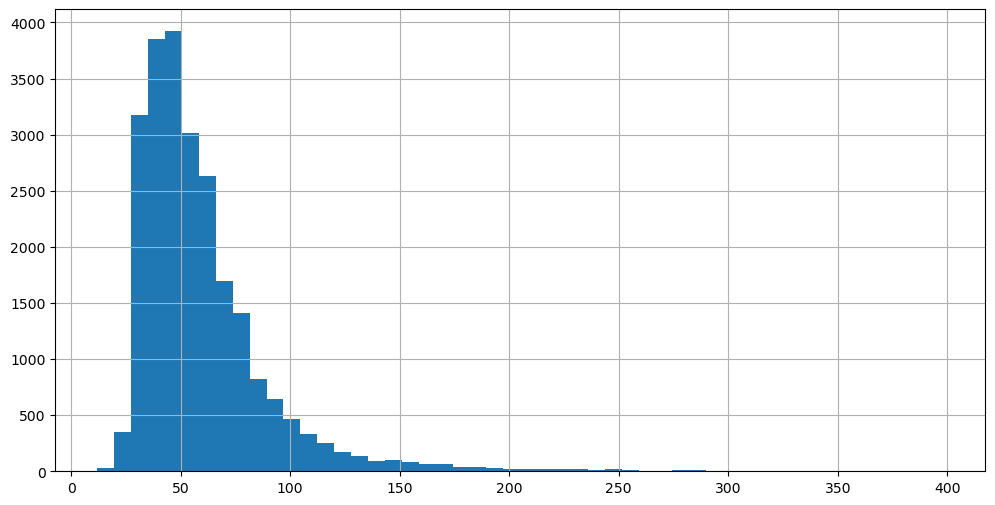

In [74]:
#общая статистика по общей площади квартир
estate_data.total_area.hist(bins=50, figsize=(12, 6));
estate_data.total_area.describe()

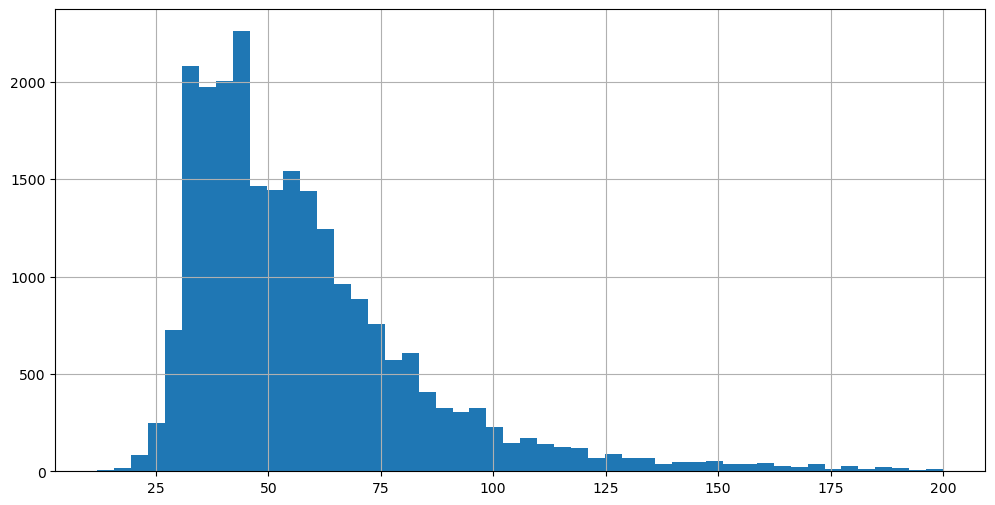

In [75]:
#ещё одна гистограмма для более подробного иследования квартир до 200 метров
estate_data.total_area.hist(bins=50, figsize=(12, 6), range=(12, 200));

В нашей выборке много небольших квартир. По большей части площадь квартир соотвествует 1, 2 и 3 комнатным квартирам. Потом должны идти по распостранённости студии и лишь затем квартиры на 4 и более комнаты и конечно, чем больше площадь (а вместе с ним и количество комнат), тем реже встречаются такие квартиры. Тут как раз всё нормально - распределение соответствует действительности. Сразу заметим небольшой хвост после преобработки - можно доочищать значения площади квартир более 320 метров квадратных.

#### Проводим исследование жилой площади квартиры

count    23580.000000
mean        33.877781
std         19.946659
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        200.000000
Name: living_area, dtype: float64

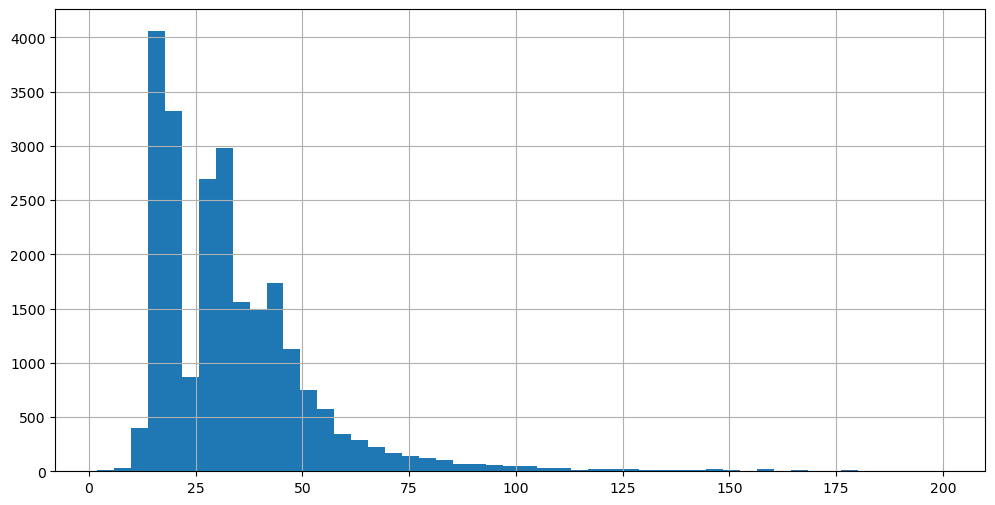

In [76]:
#общая статистика по жилой площади квартир
estate_data.living_area.hist(bins=50, figsize=(12, 6));
estate_data.living_area.describe()

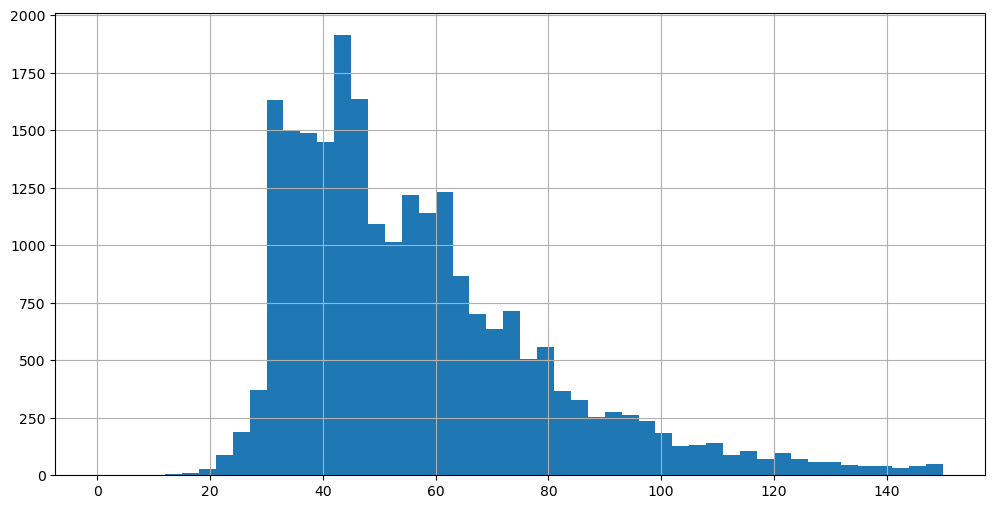

In [77]:
#ещё одна гистограмма для более подробного иследования квартир с жилой площадью до 150 метров
estate_data.total_area.hist(bins=50, figsize=(12, 6), range=(0, 150));

С жилой площадью тоже всё нормально. Во-первый график повторяет вид общей площади, что является в данном случае показателем достоверности данных. Во-вторых надо заметить, что 1ый квартиль соотвествует площади одной большой комнаты, медиана - двум комнатам, 3ий квартиль - 3 комнатам среднего размера. Это правдоподобно. Остальное - встречается уже не так часто.

#### Проводим исследование площади кухни в квартирах

count    23580.000000
mean        10.278842
std          5.322968
min          0.000000
25%          7.000000
50%          9.000000
75%         11.700000
max         63.000000
Name: kitchen_area, dtype: float64

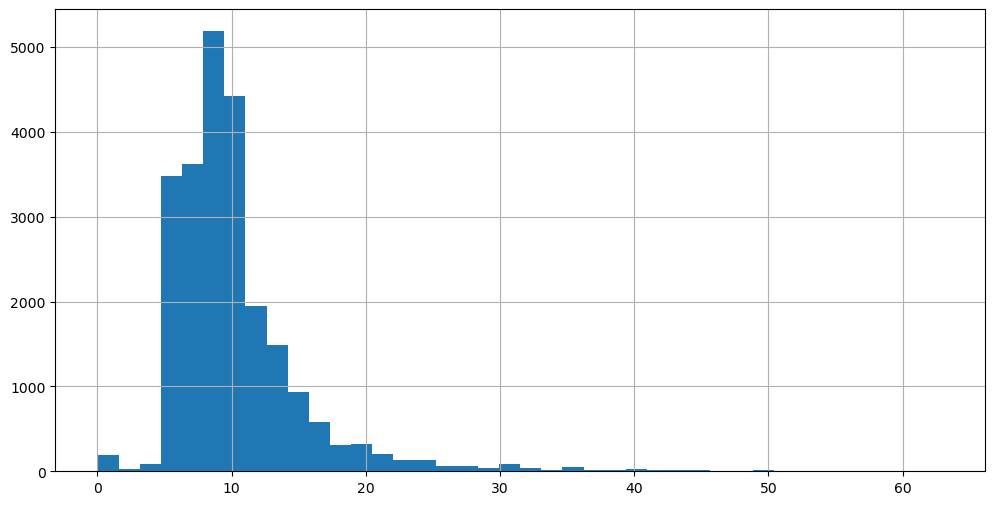

In [78]:
#общая статистика по площади кухни в квартирах
estate_data.kitchen_area.hist(bins=40, figsize=(12, 6));
estate_data.kitchen_area.describe()

Это тоже относительно правдоподобные данные. 25% квартир имеют маленькие кухни (до 7 метров), половина - немного большие до 9.5 метров, в 3/4 квартир кухни до 12 метров. Свыше 95% всех квартир имеют площадь кухни до 20 метров. В жизни так и есть. Большие кухни - гостинные - это редкость. Заметен небольшой хвост после 52 метров. Перед анализом его удалим.

#### Изучение цен на квартиры

count    2.358000e+04
mean     6.296592e+06
std      7.742087e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.750000e+06
max      3.300000e+08
Name: last_price, dtype: float64

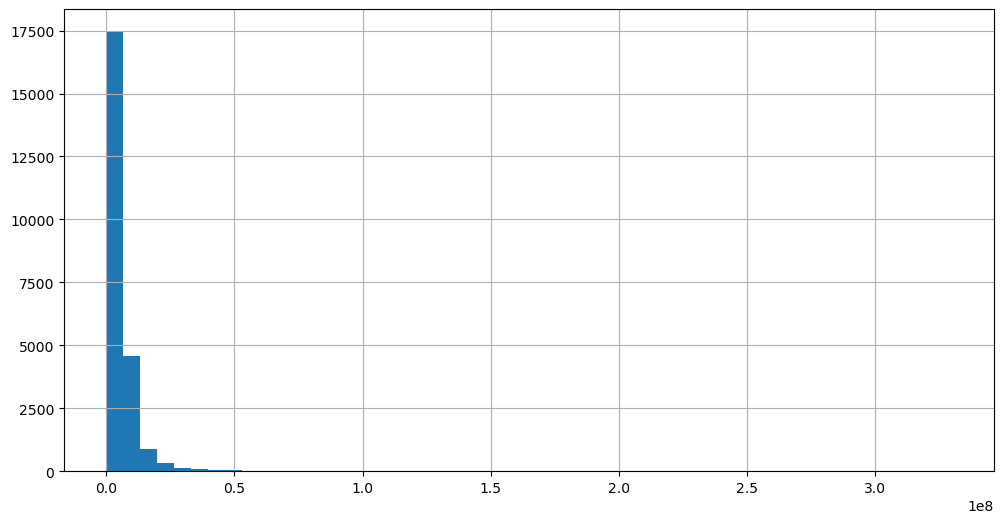

In [79]:
#общая статистика по ценам квартир
estate_data.last_price.hist(bins=50, figsize=(12, 6));
estate_data.last_price.describe()

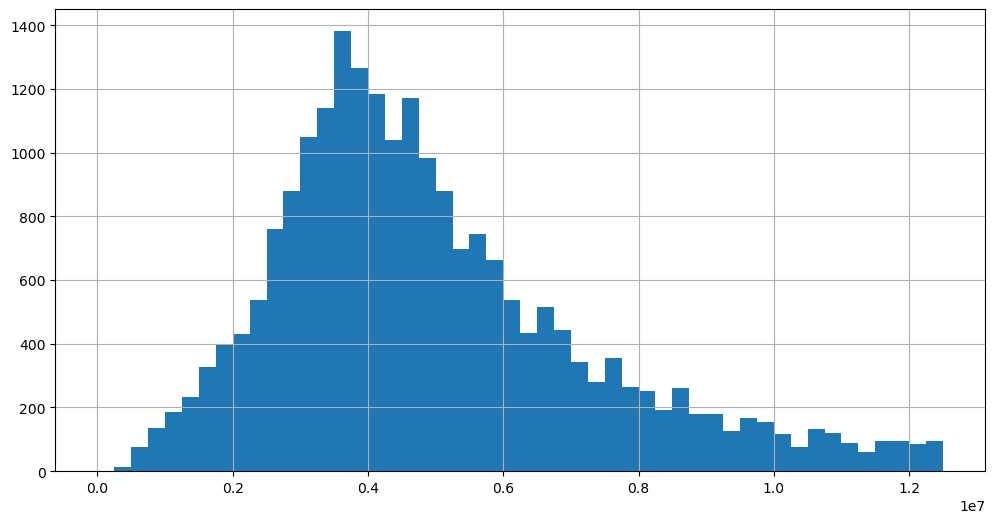

In [80]:
#более подробно про относительно не такие дорогие квартиры
estate_data.last_price.hist(bins=50, figsize=(12, 6), range=(0, 1.25e+07));

Распределение по ценам за квартиры выглядит нормально. Но с учётом очень длинного конца в дорогом сегменте. Его отбрасывать нельзя - это реальные цены на очень большие квартиры. Однако для просмотра общих тенденций цен - такие сверхдлинные хвосты можно и не учитывать. Это квартиры могут иметь совсем другую цену за метр квадратный (так называемый премиум - класс). Но это ещё предстоит посмотреть.

#### Изучение количества комнат по квартирам

count    23580.000000
mean         2.058397
std          1.037337
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: rooms, dtype: float64

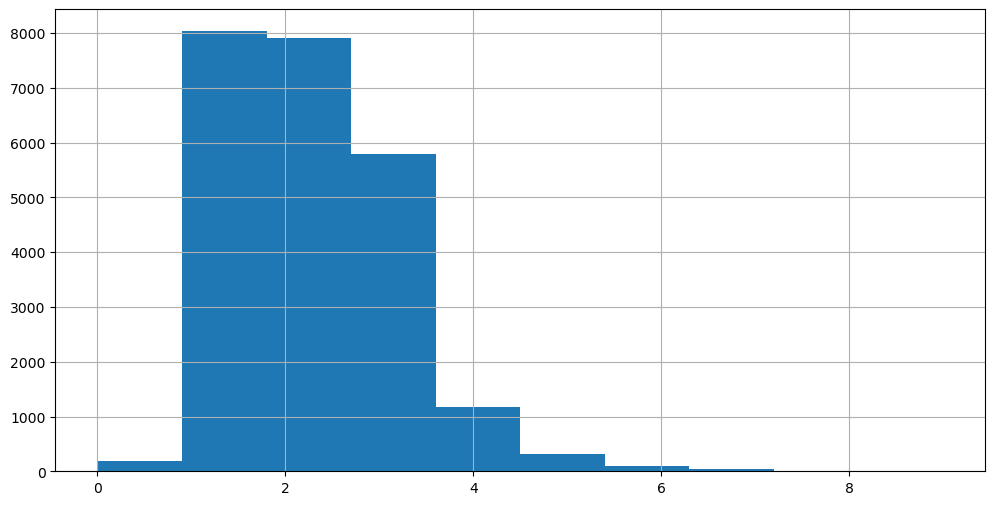

In [81]:
#общая статистика о количестве комнат в квартирах
estate_data.rooms.hist(figsize=(12, 6));
estate_data.rooms.describe()

Строго по ожиданиям. После выведения средней площади квартир - уже очевидно как должен распределяться этот параметр - 1/4 часть квартир студии и однакомнатные квартиры, половина квартир имеют не более 2 комнат, 3/4 квартир имеют не более 3 комнат. Свыше 6 комнат в квартире - редкость. По сути гистограмма похожа на распределение Пуассона, но с учётом на то, что студий у нас не много. Среднее значение и медиана отличаются не сильно.

#### Исследование столбца высота потолков

count    23580.000000
mean         2.695375
std          0.218136
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

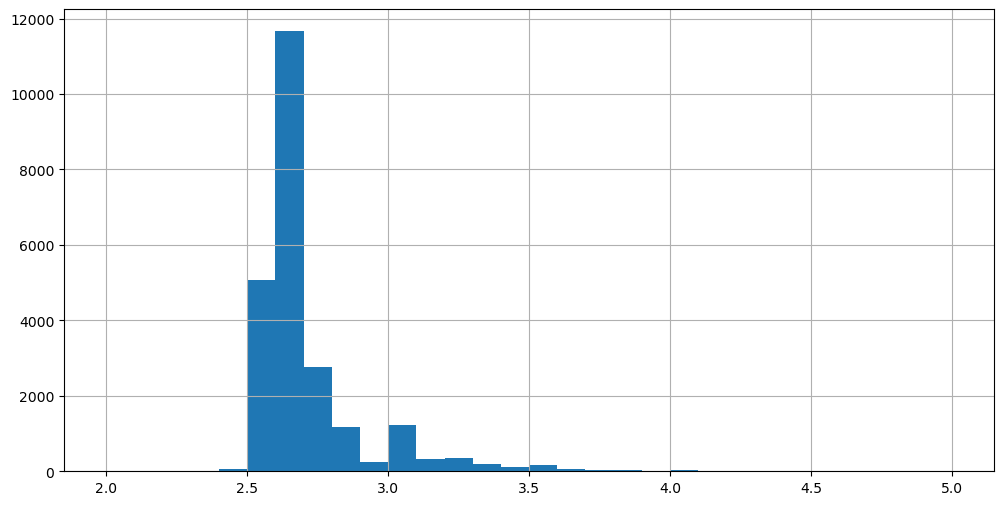

In [82]:
#общая статистика о высоте потолков в квартирах
estate_data.ceiling_height.hist(bins=30, figsize=(12, 6), range=(2, 5));
estate_data.ceiling_height.describe()

После замены всех аномальных значений более чем ожидаемо, что значения придут в норму. 2.7 метра среднее как и 3ий квартиль, но больше чем медиана (2.65 метра). Вообще отметим небольшой разброс этих значений. Разброс до 6 метров можно объянить наличием в выборке квартир старого фонда (в центре Санкт - Петербурга) с очень высокими потолками, но они очень редки.

#### Исследование этажа квартиры

count    23580.000000
mean         5.879304
std          4.859101
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

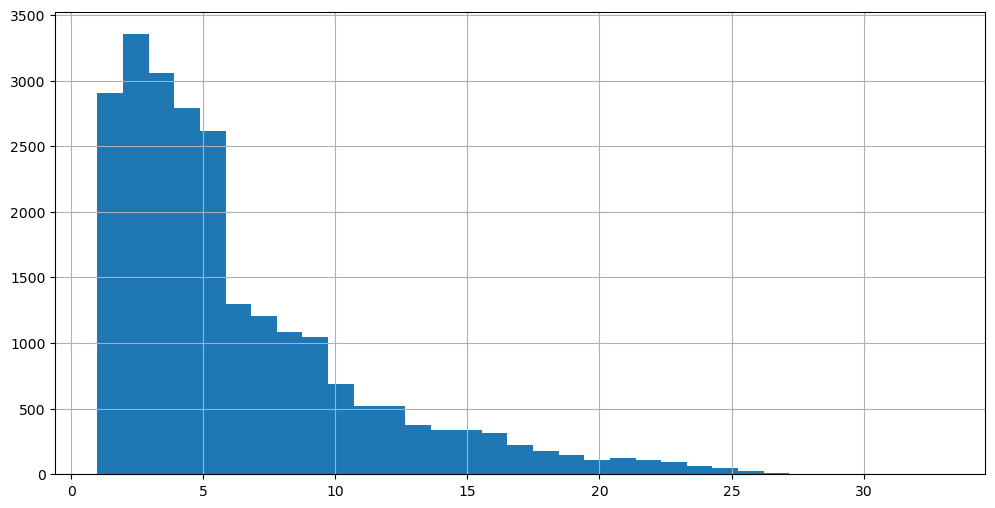

In [83]:
#общая статистика об этаже квартиры
estate_data.floor.hist(bins=33, figsize=(12, 6), range=(1, 33));
estate_data.floor.describe()

Гистограмма похожа на распредение Пуассона. В нашей выборке в большинстве предлагают квартиры на низких этажах - до 10 более 80% всех значений, а до 5го - свыше половины. Насколько это соотноситься с реальной практикой - вот тут я не уверен - не риелтор. Наверно, это связано с тем, что во-первых - не так часто делают очень большие дома, а во-вторых не всем нравиться разреженный воздух верхних этажей. Да и в определённых районах может действовать запрет на строительство домой выше определённого количества этажей.

#### Исследование типа этажа квартиры

другой       17323
последний     3349
первый        2908
Name: type_floor, dtype: int64

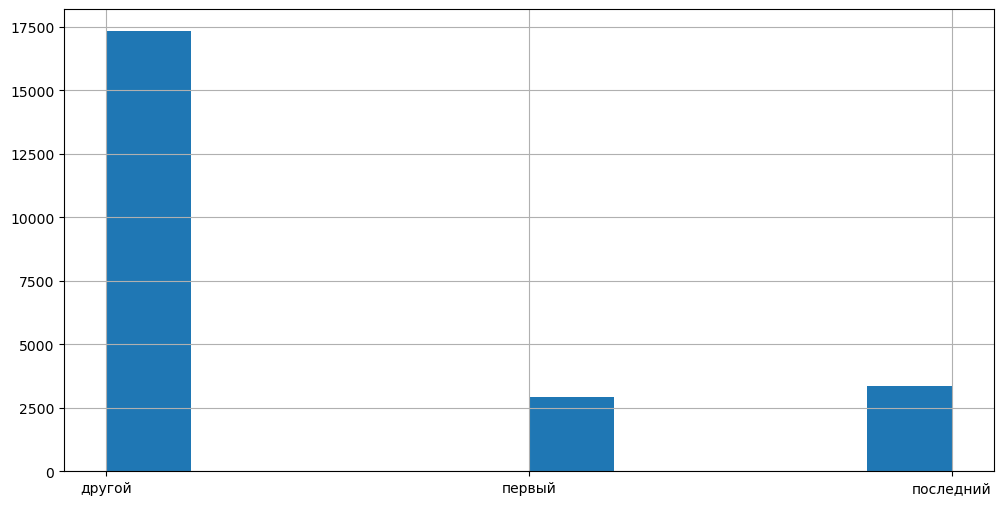

In [84]:
#общая статистка о типе этажа квартиры
estate_data.type_floor.hist(figsize=(12, 6));
estate_data.type_floor.value_counts()

Размеется, что намного чаще будут встречаться квартиры где-то по середине дома, а не первом или последнем этаже. Это связано с тем, что вариантов больше, а иногда и гораздо больше. Поэтому больше и предложений.

#### Исследование общего количества этажей в доме

count    23580.000000
mean        10.658609
std          6.525680
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

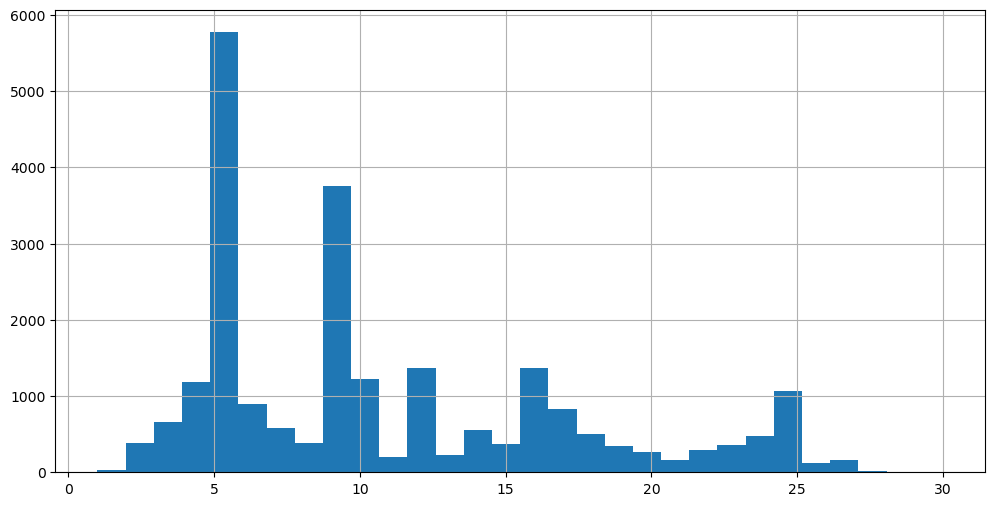

In [85]:
#общая статистика об общем количестве этажей в домах
estate_data.floors_total.hist(bins=30, figsize=(12, 6), range=(1, 30));
estate_data.floors_total.describe()

Самая распостранённая высотность домов - 4, 5, 9, 10, 12, 16 и 25 этажей - это правдоподобно.

#### Исследование расстояния до центра города

count    18064.000000
mean     14173.315047
std       8516.788038
min        181.000000
25%       9267.000000
50%      13102.500000
75%      16280.000000
max      54926.000000
Name: city_centers_nearest, dtype: float64

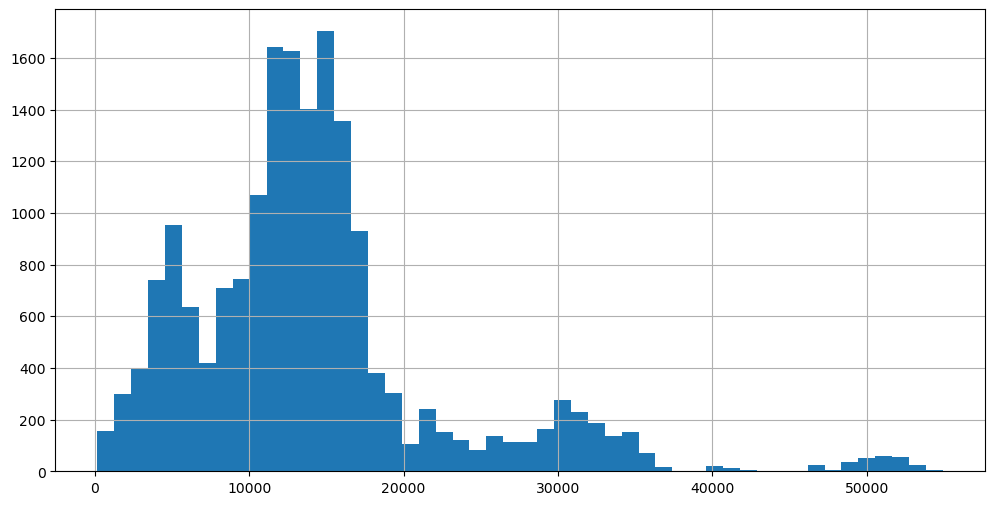

In [86]:
#общая статистика о расстоянии до центра города
estate_data.city_centers_nearest.hist(bins=50, figsize=(12, 6));
estate_data.city_centers_nearest.describe()

Более 80% квартир находится в пределах 20 км от центра города. Последний крупный всплеск находиться в пределах 50 км от центра. Скорее всего он связан с нахождением там неселённого пункта. А после 55 км находятся лишь единичные значения. 

#### Исследование расстояния до ближайшего аэропорта

count    18043.000000
mean     28783.803082
std      12586.436300
min          0.000000
25%      18551.000000
50%      26764.000000
75%      37291.000000
max      73827.000000
Name: airports_nearest, dtype: float64

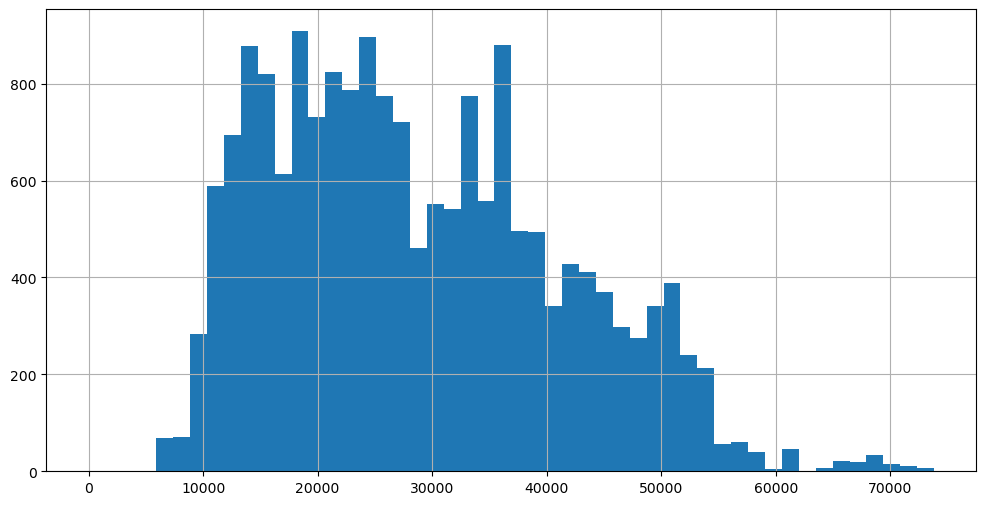

In [87]:
#общая статистика о расстоянии до ближайшего аэропорта
estate_data.airports_nearest.hist(bins=50, figsize=(12, 6));
estate_data.airports_nearest.describe()

Среднее расстояние ло аэропорта около 29 километров. Подвляющее большинство квартир находиться до 55 километров до аэропорта. Из статистики мы видим, что есть значение 0 метров до аэропорта - это тоже выброс. Мало того, что такого быть не может - квартир в здании аэропорта нет. Такое для анализа нужно удалить.

#### Исследование расстояния до ближайшего парка

count    8025.000000
mean      491.242866
std       342.301800
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

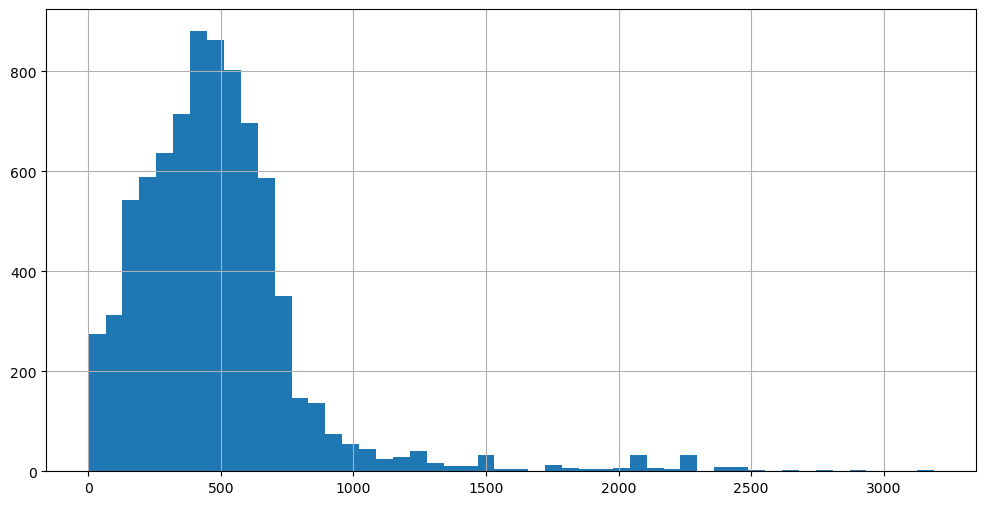

In [88]:
#общая статистика о расстоянии до ближайшего парка
estate_data.parks_nearest.hist(bins=50, figsize=(12, 6));
estate_data.parks_nearest.describe()

Большинство квартир находиться не очень далеко от парков - в пределах 500 метров. Но нам известны далеко не все значения - а всего около 44%. Это не позволяет сделать чёткий вывод и достоверность таких данных не велика. Поэтому хотя здесь (судя по гистограмме и хочется смотреть данные до 1.5 километров, но неполноста данных делает эту оценку сильно неточной.

#### Разделение по дням и месяцам публикации объявлений

3    4270
1    4161
4    3983
2    3957
0    3598
5    1924
6    1687
Name: day_publication, dtype: int64

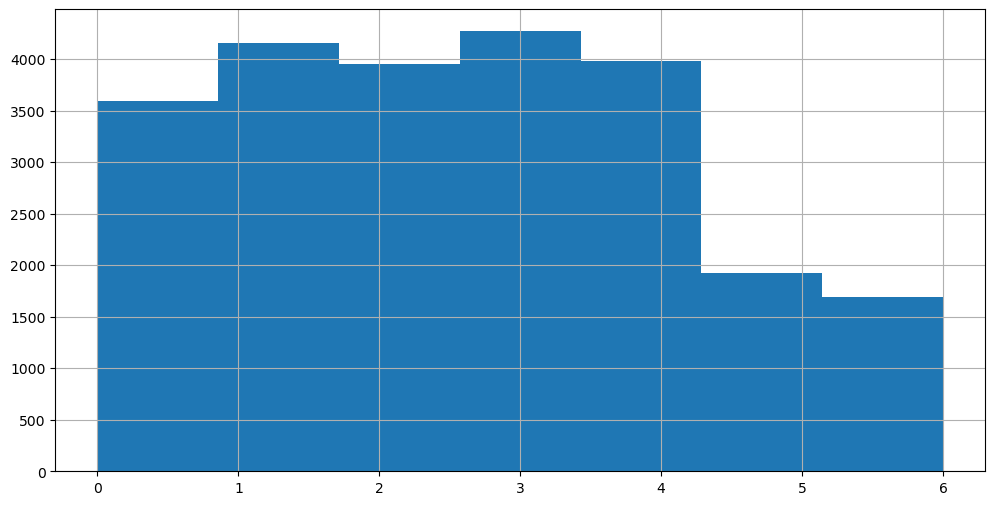

In [89]:
#разделение объявлений по дням их публикации
estate_data.day_publication.hist(bins=7, figsize=(12, 6));
estate_data.day_publication.value_counts()

2     2624
3     2574
4     2367
11    2363
10    2113
9     1972
6     1753
8     1739
7     1688
12    1632
1     1489
5     1266
Name: month_publication, dtype: int64

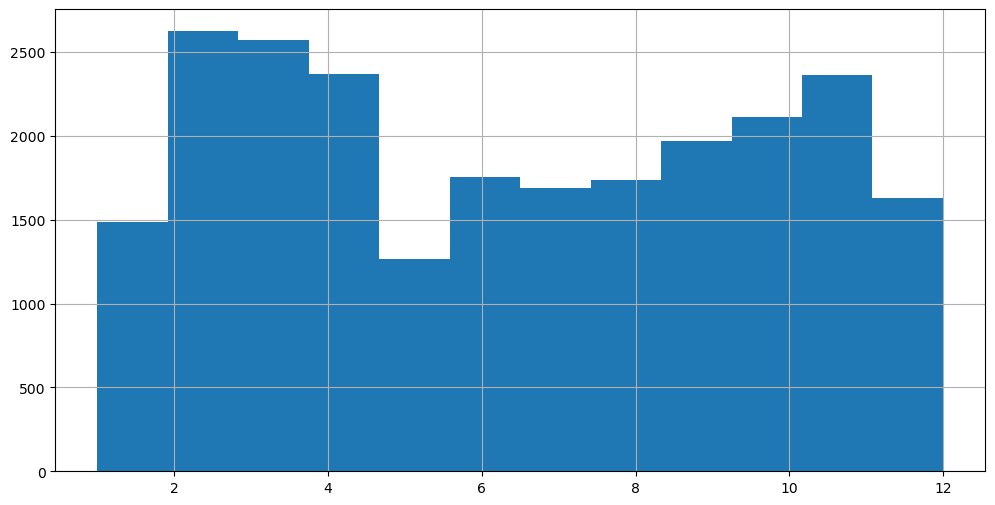

In [90]:
#разделение объявлений по месяцу их публикации
estate_data.month_publication.hist(bins=12, figsize=(12, 6));
estate_data.month_publication.value_counts()

По поводу публикаций объявления: В основном объявления публикуют по будним дням и большой разницы между ними нет, а вот в выходные публикаций в 2 раза меньше. По месяцам ситуация следующая - публиковали больше в февраль, март, апрель и ноябрь, а меньше всего - в май и январь. Объяснить можно так: по выходным большинство людей отдыхает - вот и публикаций меньше. По месяцам - январь наполовину выходной (Новый год и Рождество), май тоже из-за праздников (1 мая и День Победы). Вот и объяснение этой статистики.

#### Исследование срока продажи квартиры

count    20426.000000
mean       180.596146
std        219.225693
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

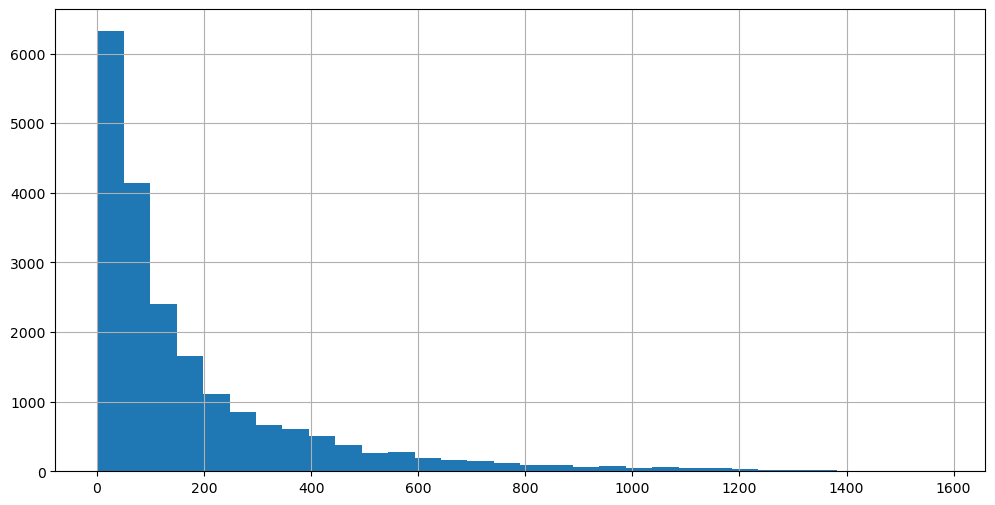

In [91]:
#срок продаж квартир
estate_data.days_exposition.hist(bins=32, figsize=(12, 6));
estate_data.days_exposition.describe()

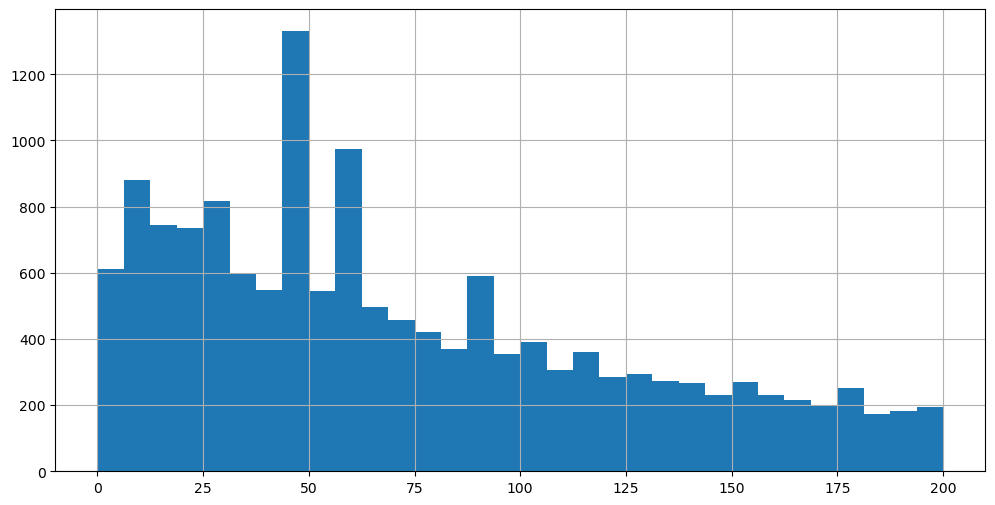

In [92]:
#рассмотрим более подробно небольшой срок продажи квартир, чтобы убедиться или опровергнуть данные о странностях распределения.
estate_data.days_exposition.hist(bins=32, figsize=(12, 6), range=(0, 200));

Есть три странных пика до 100 дней продаж. Может, они вызваны не продажами, а другими факторами? 

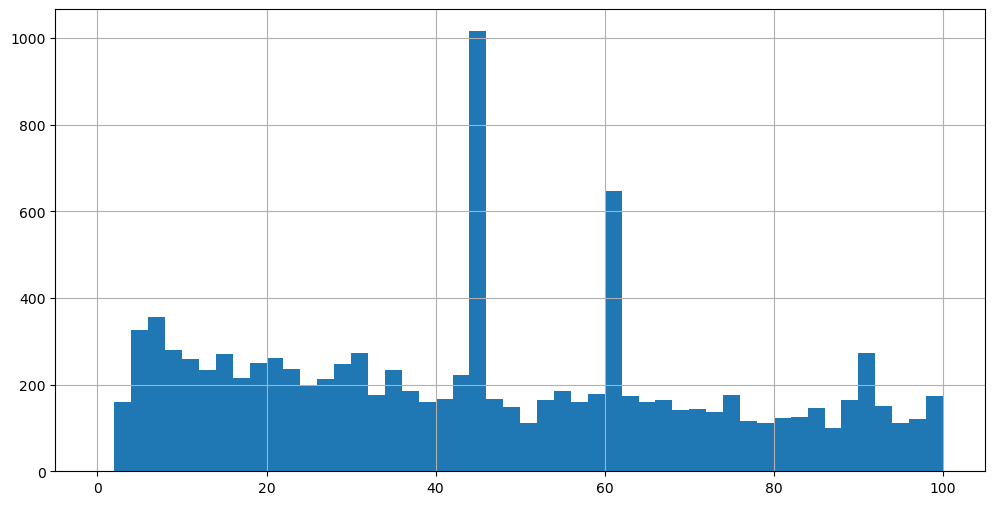

In [93]:
#укрупняем вид гистограммы для более точного определения дней с аномалиями.
estate_data.days_exposition.hist(bins=50, figsize=(12, 6), range=(0, 100));

Странные пики приходятся на примерно 45 день, 60 день и 90 день. И это не продажи, а сроки объявлений и их снятие. Их нужно удалять, а потом заново считать.

In [94]:
#Удаляем аномалии в столбце days_exposition
estate_data = estate_data.query("days_exposition not in [45, 60, 90] | days_exposition.isna()")

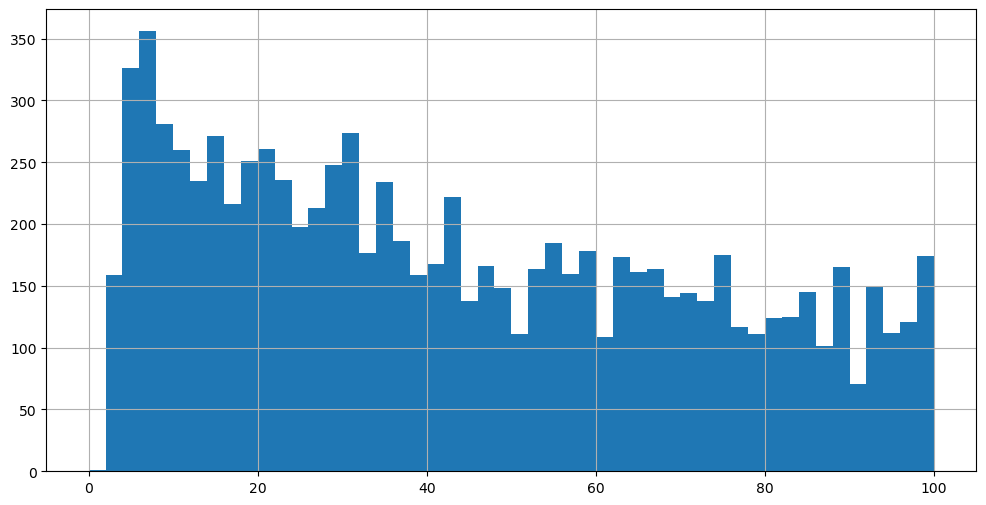

In [95]:
#убедимся,что всё удалилось успешно - строим график как предведущий
estate_data.days_exposition.hist(bins=50, figsize=(12, 6), range=(0, 100));

Всё чисто - пора повторно снимать статистику и строить общий график.

count    18807.000000
mean       191.354126
std        225.210037
min          1.000000
25%         41.000000
50%        110.000000
75%        252.000000
max       1580.000000
Name: days_exposition, dtype: float64

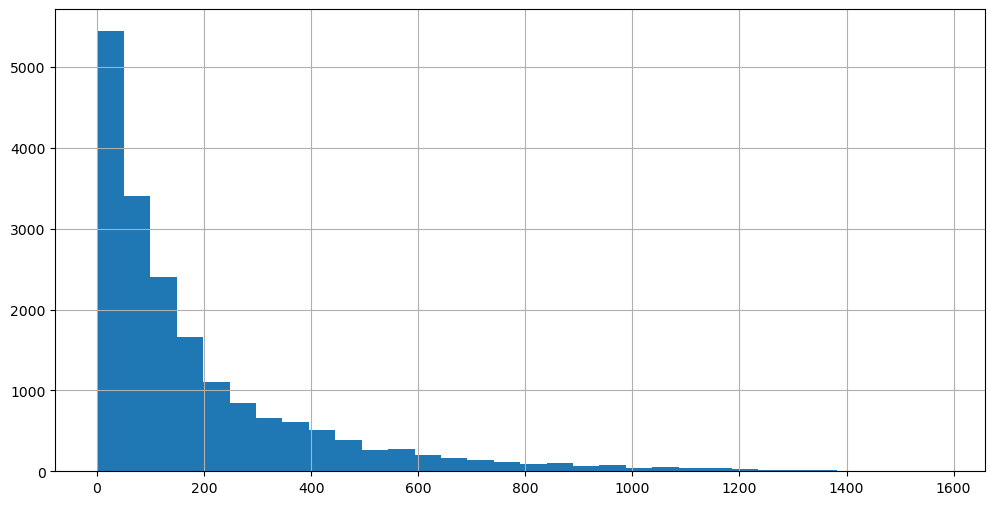

In [96]:
#срок продаж квартир (после прочистки)
estate_data.days_exposition.hist(bins=32, figsize=(12, 6));
estate_data.days_exposition.describe()

Продажа квартиры в среднем занимает 191 день. Но при этом половина всех продах происходит в пределах 110 дней. Конечно, при этом будет очень большой разброс по скорости продажи квартиры (так и есть стандартное отклонение  целых 225 дней!). Быстрой продажей можно назвать продажу до 90 дней, а очень долгие продажи от 800 дней (с рекордом в 1580 дней). На снятиях объявлений было удалено немногим больше 1600 строк, что составляет 6.83% от начальных данных.

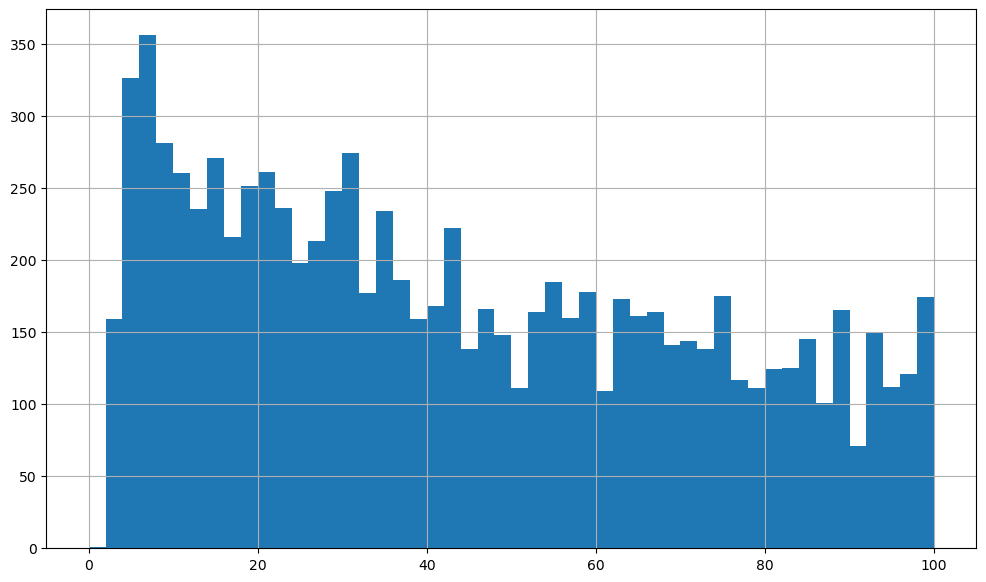

In [97]:
# Код ревьюера
estate_data['days_exposition'].hist(bins=50, range=(0,100), figsize=(12, 7));

### Влияние факторов на полную стоимость объекта

In [98]:
#доочищаем данные после конткретного обзора всех столбцов (избавление данных от оставшихся выбросов)
estate_data = estate_data.query("airports_nearest > 1000 | airports_nearest.isna()")
estate_data = estate_data.query("total_area <= 320")
estate_data = estate_data.query("kitchen_area <= 52")

#считаем количество оставшихся данных
shape_final = estate_data.shape
print(shape_final)

#доля от начальных данных годных для анализа
print(f'{(shape_final[0] / shape_before[0]):.2%}')

(21935, 28)
92.56%


,total_area,last_price
total_area,1.000000,0.677858
last_price,0.677858,1.000000


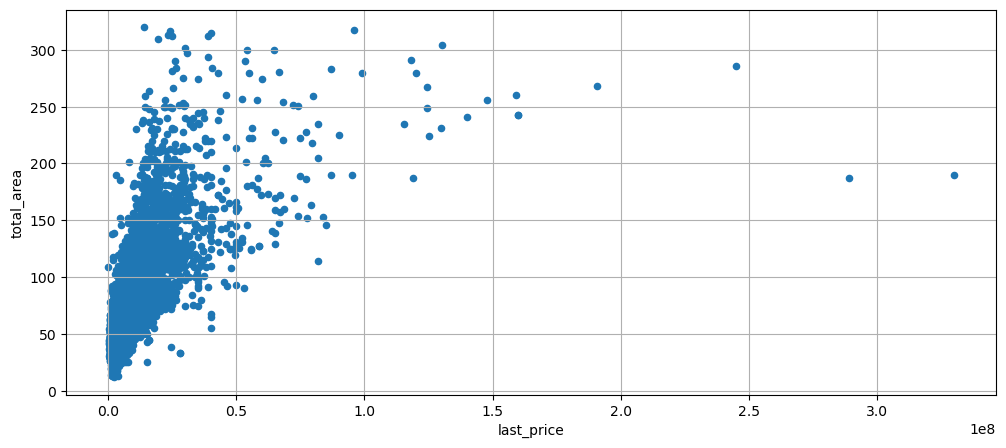

In [99]:
#влияние общей площади на цену
estate_data.plot(x='last_price', y='total_area', kind='scatter', figsize=(12, 5), grid=True);
estate_data[['total_area', 'last_price']].corr()

Взаимосвязь между площадью и ценой достаточно сильна и она явно положительная. Чем больше квартира - тем больше она стоит. Параметр описывает 67.79% изменчивости фактора цены.

,living_area,last_price
living_area,1.000000,0.601852
last_price,0.601852,1.000000


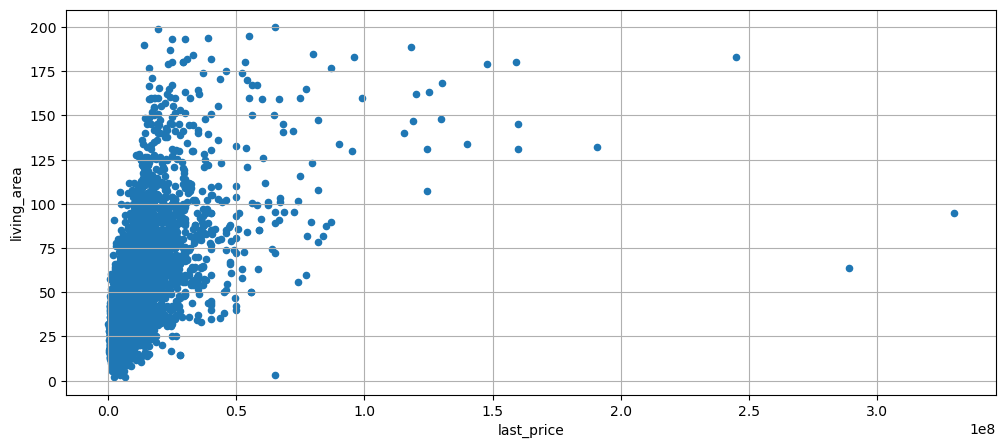

In [100]:
#изучаем влияние жилой площади на цену
estate_data.plot(x='last_price', y='living_area', kind='scatter', figsize=(12, 5), grid=True);
estate_data[['living_area', 'last_price']].corr()

Взаимосвязь между жилой площадью и ценой достаточно сильна и она явно положительная. Чем больше жилая площадь - тем больше стоит квартира. Параметр описывает 60.19% изменчивости фактора цены. Влияет меньше, так как не учитывает в отличие от прошлого параметра нежилые помещения квартиры (кухню, коридоры, прихожую, балконы).

,kitchen_area,last_price
kitchen_area,1.000000,0.498674
last_price,0.498674,1.000000


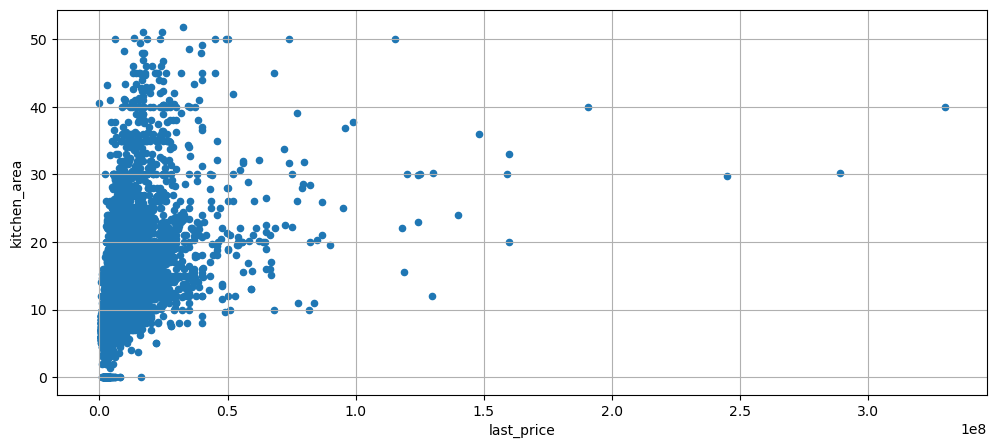

In [101]:
#изучаем влияние площади кухни на цену
estate_data.plot(x='last_price', y='kitchen_area', kind='scatter', figsize=(12, 5), grid=True);
estate_data[['kitchen_area', 'last_price']].corr()

Взаимосвязь между площадью кухни и ценой существует. Эта взаимосвязь положительная. Чем больше кухня - тем дороже квартира. Параметр описывает 49.87% изменчивости фактора цены. Влияет меньше, чем даже жилая площадь. По причине того, что не всегда в большей квартире кухня больше, чем в относительно более маленькой.

,rooms,last_price
rooms,1.000000,0.395506
last_price,0.395506,1.000000


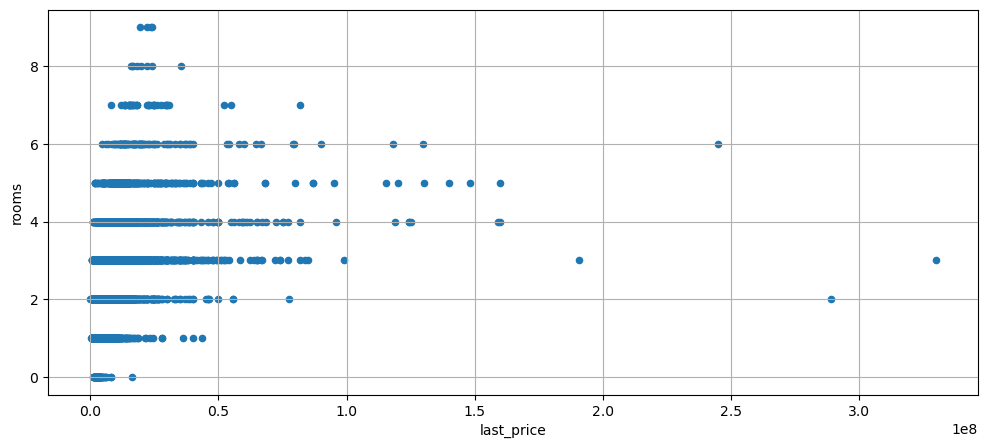

In [102]:
#изучаем влияние количества комнат на цену
estate_data.plot(x='last_price', y='rooms', kind='scatter', figsize=(12, 5), grid=True);
estate_data[['rooms', 'last_price']].corr()

Взаимосвязь между количеством комнат и ценой существует. Она положительная, но уже не очень сильная. Описывает 40.58% изменчивости цены. Очевидно размер квартиры имеет гораздо большее влияние, чем количество комнат.

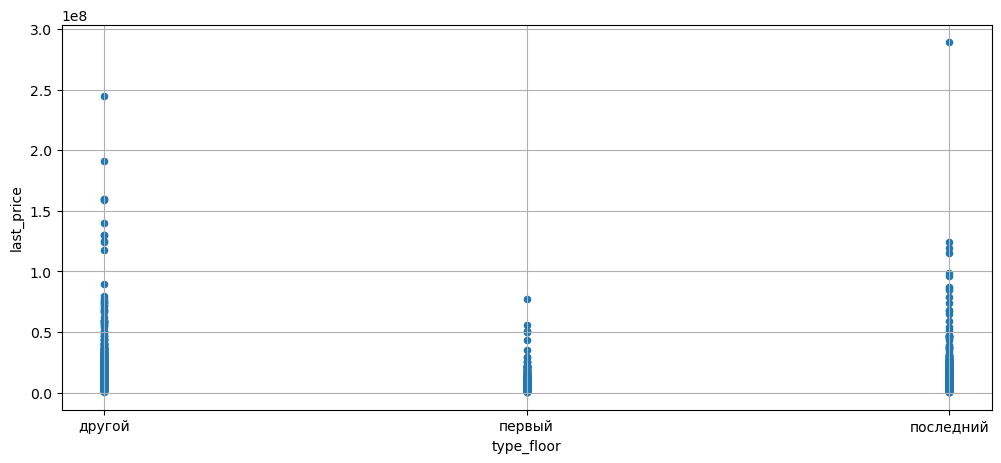

In [103]:
#изучаем влияние этажа на котором находится квартира на цену
floor_price = estate_data.groupby(['type_floor', 'total_area'], as_index=False).last_price.mean()
floor_price.plot(x='type_floor', y='last_price', kind='scatter', figsize=(12, 5), grid=True);

Влияние этажа на цену при пожем количестве комнат/общей площади таково: Первый этаж будет относительно дешевле, чем любой другой, включая в том числе и последний. А последний в целом должен быть дешевле, чем любой другой. Вспоминаем - на первом этаже может не быть балкона, прочий шум с улица лучше может быть слышен, да и уровень света (естественного) ниже, чем на любом другом. У последнего этажа может быть лучше слышен шум при осадках (дожди, ливни), иногда очень высоко подниматься, но иногда может быть свой выход на крышу и даже своя зона на крыше, что конечно, неплохо. может с этими факторами и обусловлен сильный выброс на последнем этаже.

,day_publication,last_price
day_publication,1.000000,-0.152014
last_price,-0.152014,1.000000


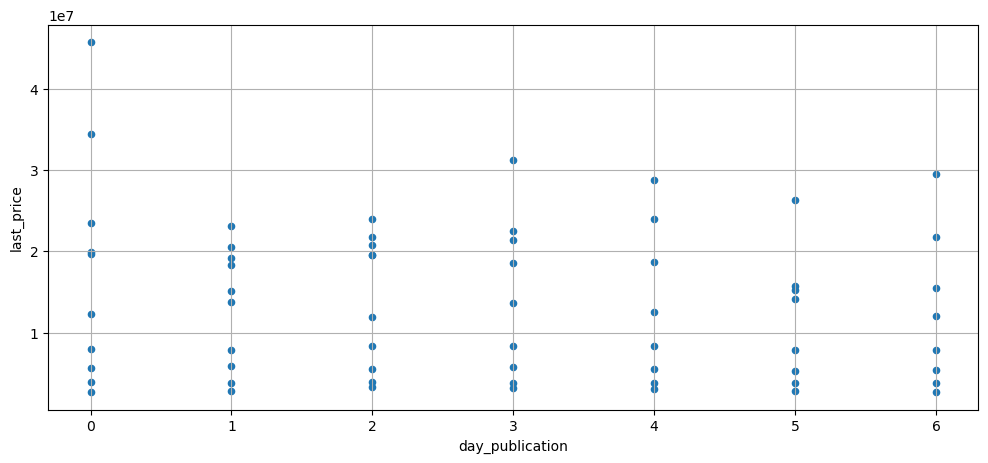

In [104]:
#день размещения объявления и его влияние на цену
day_price = estate_data.groupby(['day_publication', 'rooms'], as_index=False).last_price.mean()
day_price.plot(x='day_publication', y='last_price', kind='scatter', figsize=(12, 5), grid=True); 
day_price[['day_publication', 'last_price']].corr()

Квартиры, выставленные в начале недели оказались относительно дороже, тех, что выставлены в конце недели. Взаимосвязь между днём публикации объявления и ценой квартиры слабая.

,month_publication,last_price
month_publication,1.000000,0.044703
last_price,0.044703,1.000000


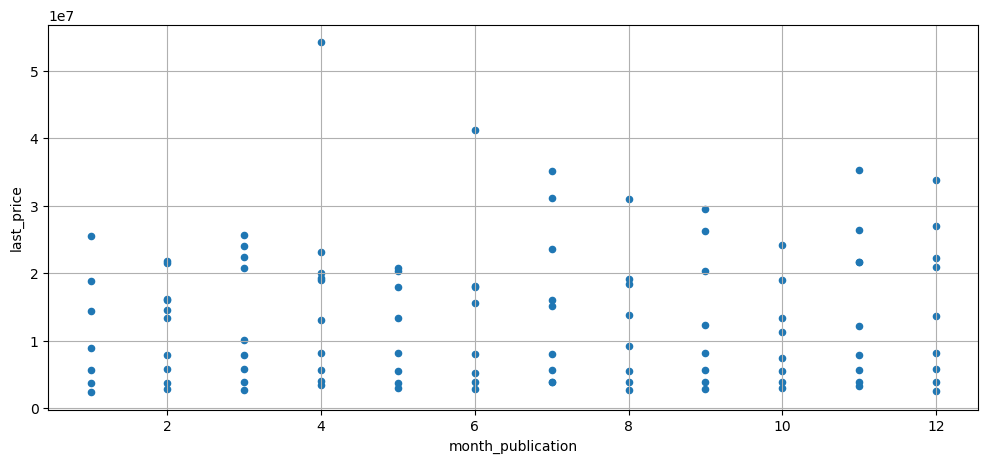

In [105]:
#месяц размещения объявления и его влияние на цену
month_price = estate_data.groupby(['month_publication', 'rooms'], as_index=False).last_price.mean()
month_price.plot(x='month_publication', y='last_price', kind='scatter', figsize=(12, 5), grid=True); 
month_price[['month_publication', 'last_price']].corr()

Взаимосвязи между месяцем публикации и ценой можно сказать, что нет.

,year_publication,last_price
year_publication,1.000000,-0.052201
last_price,-0.052201,1.000000


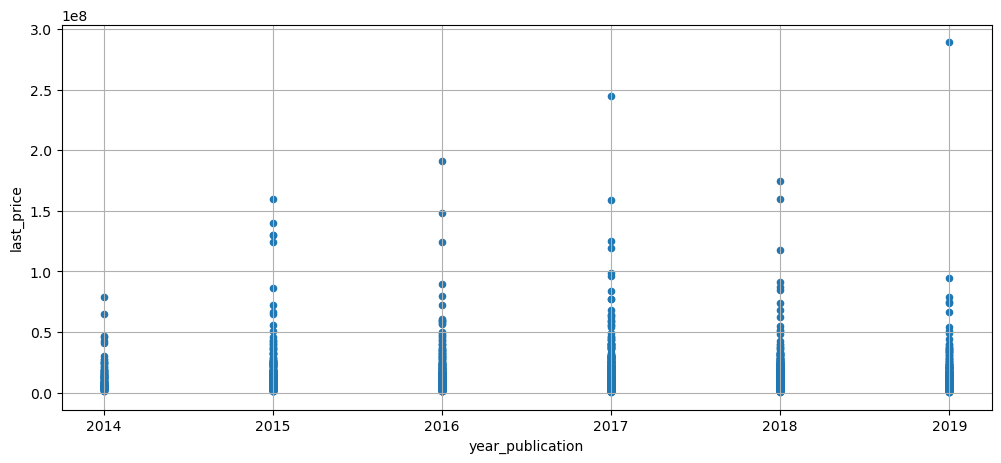

In [106]:
#год размещения объявления и его влияние на цену
year_price = estate_data.groupby(['year_publication', 'total_area'], as_index=False).last_price.mean()
year_price.plot(x='year_publication', y='last_price', kind='scatter', figsize=(12, 5), grid=True);
year_price[['year_publication', 'last_price']].corr()

Взаимосвязь между годом публикации и ценой квартир крайне слабая. По графику выделим только 2014 год, как самый низкий по цене. Остальное вообще не заметно.

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.677858,0.601852,0.498674,0.395506
total_area,0.677858,1.000000,0.939878,0.602852,0.784619
living_area,0.601852,0.939878,1.000000,0.411942,0.856785
kitchen_area,0.498674,0.602852,0.411942,1.000000,0.271813
rooms,0.395506,0.784619,0.856785,0.271813,1.000000


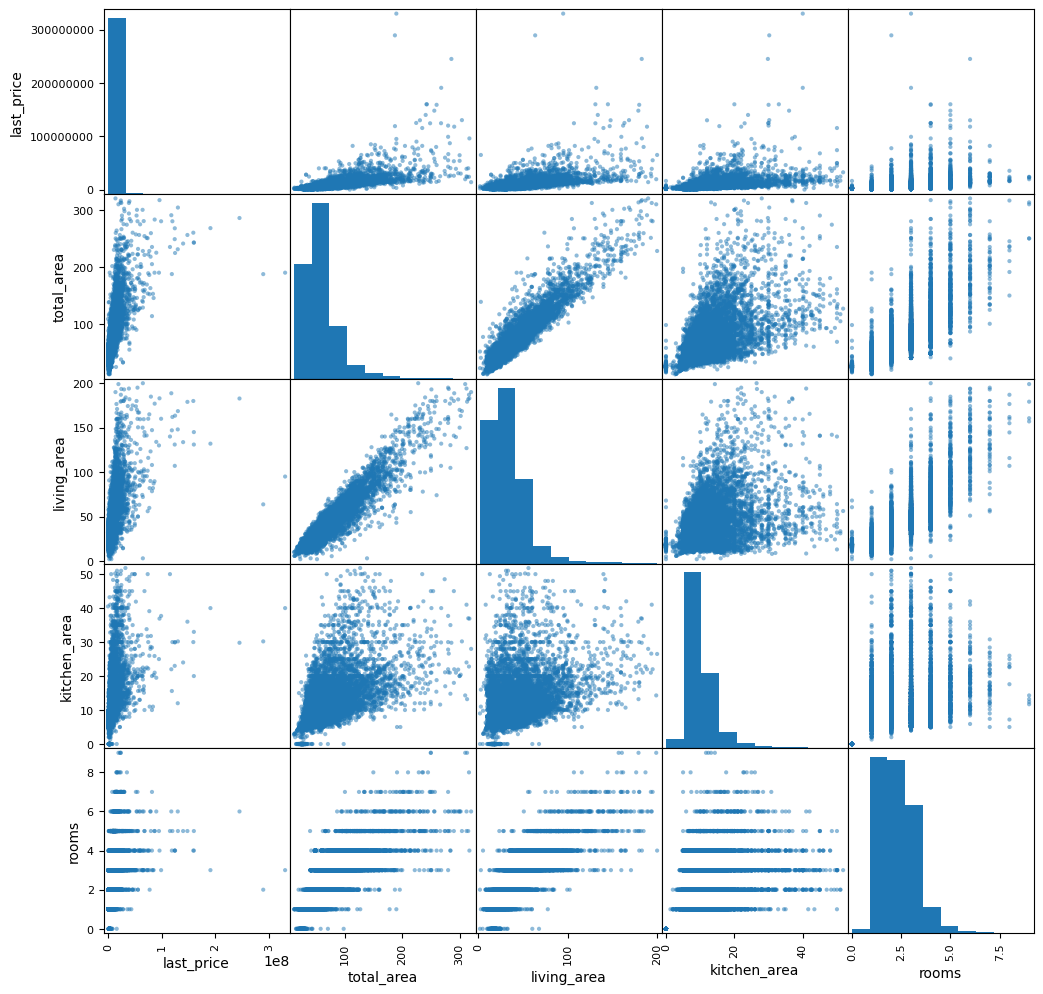

In [107]:
#Финальные исследования - полная взаимосвязь между ценой, площадью общей, площадью кухни, жилой площади, количества комнат
dependency_table = estate_data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms']]
pd.plotting.scatter_matrix(dependency_table, figsize=(12, 12))
dependency_table.corr()

Из нового, что узнали - это очень сильная зависимость между жилой площадью и общей площадью (более 94%). Это будет приводить к тому, что если нужно проводить будет анализ влияния сразу нескольких факторов на цену, то из двух факторов жилой площади и общей площади нужно выбирать один. И поскольку общая площадь влияет сильнее нужно будет оставлять её.

### Исследование средней цены одного квадратного метра площади в 10 населённых пунктах с наибольшим числом объявлений

In [108]:
#получаем топ-10 самых популярных мест по числу объявлений
popular_place = estate_data.groupby('locality_name').total_area.count()
lst_popular_place = list(popular_place.sort_values(ascending=False).head(10).index)
lst_popular_place

['санкт-петербург',
 'поселок мурино',
 'поселок шушары',
 'всеволожск',
 'пушкин',
 'колпино',
 'поселок парголово',
 'гатчина',
 'деревня кудрово',
 'выборг']

In [109]:
#отбираем нужные данные
select_estate_data = estate_data.query('locality_name in @lst_popular_place')

In [110]:
#находим населённые пункты с самой дешёвым и самым дорогим жильём за метр квадратный
select_estate_data.groupby('locality_name').price_square_meter.mean().sort_values()

locality_name
выборг                58113.815407
гатчина               68407.478275
всеволожск            68616.483315
колпино               75620.732557
поселок шушары        78891.526807
поселок мурино        85519.481327
поселок парголово     90569.193574
деревня кудрово       92170.386816
пушкин               103267.828563
санкт-петербург      114037.232988
Name: price_square_meter, dtype: float64

Самая дешёвая цена за метр квадратный площади среди самых популярых мест находиться в Выборге, в Гатчине и Всеволожске. А самая дорогая в Санкт - Петербурге, Пушкине и в деревне Кудрово.

### Исследование стоимости квартир в Санкт - Петербурге в зависимости от их удалённости от центра города

In [111]:
#отбираем квартиры в Санкт - Петербурге
spb_estate = estate_data.query("locality_name == 'санкт-петербург'")

#группируем данные по удалённости от центра города
distance_price_spb = spb_estate.groupby('distance_to_center', as_index=False).agg({'price_square_meter': ['mean', 'median', 'std']}).sort_values(by='distance_to_center')
distance_price_spb

distance_to_center price_square_meter                           
                                    mean      median            std
0                 0.0      241778.673750  164074.505  172319.389941
1                 1.0      179265.978343  129166.670  191970.125671
2                 2.0      153280.118427  121590.635  104493.060527
3                 3.0      121189.721829  108097.545   53963.418979
4                 4.0      129725.160558  117235.770   55390.430235
5                 5.0      136847.781481  127137.615   54117.909774
6                 6.0      146958.998686  131795.450   73675.973194
7                 7.0      154100.793909  125095.685   82839.929668
8                 8.0      124589.812531  122516.550   37583.684440
9                 9.0      113116.140712  105764.120   32438.895305
10               10.0      112935.532769  106741.580   30629.970699
11               11.0      108568.942744  103346.440   27767.266770
12               12.0      107518.684117  104077.015   22698.040416
13               13.0      107971.263210  104121.380   23025.444252
14               14.0      104169.261549  101983.010   18959.825766
15               15.0      104441.588176  101492.870   21486.110604
16               16.0      100474.861801   97500.000   19924.696641
17               17.0       96828.552380   94142.160   20295.720102
18               18.0       96736.580697   95419.585   19229.224823
19               19.0       98119.269315   97461.750   20964.895442
20               20.0       86713.268750   86950.365   14143.832936
21               21.0       94470.253738   89500.000   19358.076856
22               22.0       90487.134837   88223.090   17395.545606
23               23.0       90650.823250   89815.525   19409.379311
24               24.0       83990.855238   86184.840   13449.910839
25               25.0       92613.743810   94324.320   15975.429430
26               26.0       88968.299184   89717.950   12443.510629
27               27.0      132115.710000  132115.710   87402.937780
28               28.0       81161.914286   79372.090   14633.339774
29               29.0       72953.363333   76084.735   13933.839174

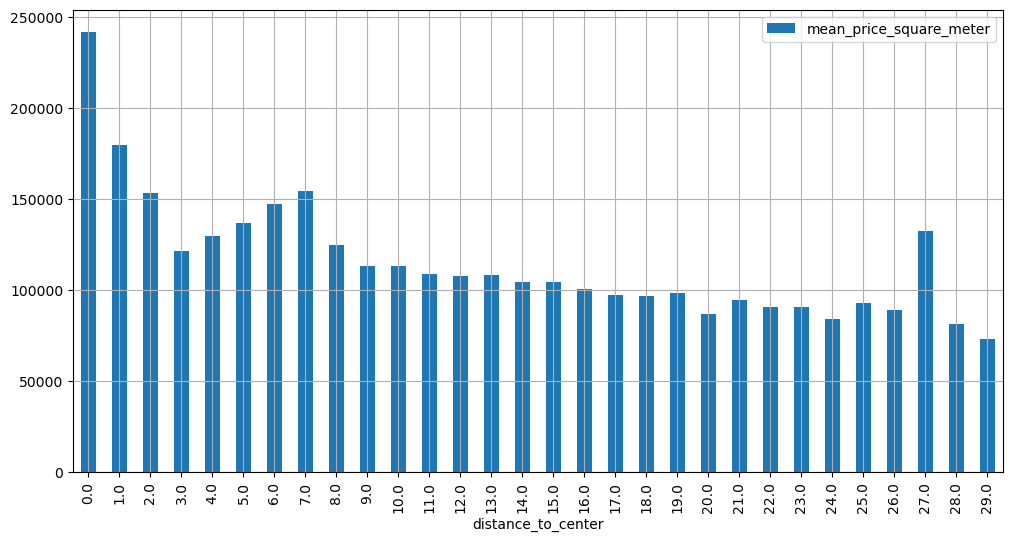

In [112]:
#переименовываем столбцы для избавления от мультииндексов
distance_price_spb.columns = ['distance_to_center', 'mean_price_square_meter', 'median_price_square_meter', 'std_price_square_meter']

#строим столбчатый график по ценам/отдалённости от центра
distance_price_spb.plot(x='distance_to_center', y='mean_price_square_meter', kind='bar', grid=True, figsize=(12, 6));

Как и ожидалось - самые дорогие квартиры находятся в самом центре города - до 1км от центра. Средняя цена - 241 т.р. за квадратный метр. Дальше дорогие квартиры оказались в 1, 2, 6 и 7 километрах от центра - цены от 146 т.р. за квадратный метр. также есть и очень дорогие квартиры на что указывает большое стандратное отклонение. Вообще очень хорошо видна зависимость - до 3 километра от центра города цена падает, с 3 по 7 километр от центра города цена растёт, а далее планомерно падает, кроме одного всплеска на 27ом километре от центра города. Отдельно про этот всплеск в 27 километрах от центра города - там средняя цена сопоставима с 5ым километром от центра города. Это достигается лишь из-за очень дорогих квартир там, на что указывает очень большое значение стандартного отклонения (оно уступает лишь самому центру города - до 3 километров от центра).

## Общий вывод

На цену квартиры влияют в порядке от самого важного к наименее значимому:
- общая площадь квартиры
- жилая площадь квартиры
- площадь кухни
- количество комнат

Далее надо отметить, что если квартира аналогичная по количеству комнат будет находиться на первом этаже она будет относительно дешевле, чем схожая квартира на любом другом этаже. Потом последний этаж будет относительно дешевле, чем любой другой, кроме первого. Дата публикации практичемки никак не влияет на цену квартиры. Но отметим, что на выходных днях подаётся значительно меньше заявок на продажу квартиры, чем в любой из будних дней. И также заметим, что заявки поданные в 2014 году оказались относительно самыми дешёвыми по сравнению с другими годами.

Самые распостранённые места для продажи квартир - Санкт-петербург, поселок Мурино, поселок Шушары, Всеволожск, Пушкин, Колпино,
поселок Парголово, Гатчина, деревня Кудрово, Выборг. Из них самые дорогие - Санкт - Петербург, Пушкин и деревня Кудрово. А самые дешёвые их них - Выборг, Гатчина, Всеволожск. В самом городе Санкт - Петербурге в целом действует негласное правило: чем дальше от центра города, чем дешевле цена за метр квадратный. Но это не абсолютно: в пределах от 3 до 7 километров от центра города цена растёт с отдалением , а уже с 8 километра снова падает, а также очень сильно выделяется ещё 27ой  километр от центра города - там достаточно много дорогих квартир - с чем это всязано пока не совсем ясно.

Можно также отметить интересный факт: даже если квартира находиться на первом этаже - это далеко не всегда означает отсуствие балкона в квартире, хотя и на более высоких этажах шанс на то, что будет балкон значительно больше, в некоторых случаях может быть и два балкона на квартиру, если квартира не на 1ом этаже. 

В среднем на продажу квартиры уходит немногим более полугода, но половина квартир продаётся в течение 110 дней. Продажу квартиры можно считать долгой или даже очень долгой, если она не продаётся за 800 дней. И последнее: обратим внимание на момент - если исследовать влияние сразу нескольких факторов на цену квартиры - надо брать или общую площадь квартиры или жилую площадь квартиры из-за слишком сильной корреляции между собой, иначе можно получить искажённые данные.